# Description

- Auteurs: Simona MILADINOVA & Seydou DIA

- Objectif du Notebook: Analyse et prédiction du taux de remplissage de disques durs <br>

**date de création** : 05/02/2021 <br>
**dernière maj**: 25/02/2021


L'objectif de ce Notebook est de réaliser l'analyse de l'espace de stockage de 50 disques durs issus des serveurs de l'entreprise INFOLOGIC.

La première partie consiste en un pré-traitement des données, la seconde partie présente une première analyse des données de consommation. Ensuite un clustering des différents disques durs sera réalisé pour identifier les différents types d'évolutions de stockage. Enfin, des modèles de prédictions seront testés dans la dernière partie sur certains des disques durs.


*Cette étude a été réalisé dans le cadre du parcours Recherche CIX de 5ème année du département génie électrique de l'INSA Lyon.* <br>
_Bien que le texte descriptif du projet est en français, nous avons fait le choix de commenter le code en anglais._

# Setup

In [1]:
# To prettify plots
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Import

In [ ]:
# os packs
from os import environ as env
from os.path import join

# data packs
import pandas as pd
import missingno as msno 
import numpy as np

# time packs
import datetime as dt
from datetime import datetime
from datetime import timedelta

# stats packs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pymannkendall as pmk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# visual packs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from pandas.plotting import lag_plot

# ml packs
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
from sklearn.metrics import mean_squared_error
from math import sqrt

# others
from scipy.fftpack import fft, ifft, fftshift
from scipy.fft import fftfreq
from scipy.signal import periodogram
import pickle

## Paths

In [3]:
# If you want to use this notebook, do not forget to adapt the path to your environment.

DIR_ROOT = join(env["CODE_PATH"], "CIX") # project path
DIR_RAW = join(DIR_ROOT, 'Raw Data') # raw data path
DIR_PROC = join(DIR_ROOT, 'Proc_Data') # processed data path

CSV_PATH = join(DIR_RAW, 'AvailableDisksPercentage.csv') # raw table path
PROC_CSV = join(DIR_PROC, "hourly.csv") # processed table path

# path to clusters results
PROC_KM_STD_NORM = join(DIR_PROC, 'km_std_norm_hourly.pkl')
PROC_KM_STD_NORM_3CLS = join(DIR_PROC, 'km_std_norm_3cls_hourly.pkl')

PROC_KM_NORM_4CLS = join(DIR_PROC, 'km_norm_4cls_hourly.pkl')
PROC_KM_NORM_3CLS = join(DIR_PROC, 'km_norm_3cls_hourly.pkl')


## Utils

La fonction ci-dessous a été développée pour faciliter les plots des fonctions d'autocorrélations. Le lecteur pourra revenir à cette cellule s'il désire en apprendre plus.

In [4]:
def plot_cf(timeseries, lags=15):
    
    """This function plots both ACF and PACF of a given timeseries with confidence interval.
    
    Parameters
    ----------
    timeseries(pd.Series/list): timeseries on which the ACF and PACF will be applied
    lags(integer): maximum lag to plot
    
    Returns
    ----------
    None
    """
    
    arr_acf, confint_acf = acf(timeseries, nlags=lags, alpha=0.05)
    arr_pacf, confint_pacf = pacf(timeseries, nlags=lags, alpha=0.05)
    
    
    print(len(arr_acf))
    fig, axs = plt.subplots(2, 1, sharex=True,
                        figsize=(7, 7))
    
    
    x_lags = [float(i) for i in range(lags+1)]
    
    x_lags[0] -= 0.5
    x_lags[-1] += 0.5
     
    
    # ACF Plot
    acf_ax = axs[0]
    acf_ax.bar(range(lags+1), arr_acf)
    acf_ax.plot()
    acf_ax.set_ylim(-1.2,1.2)
    acf_ax.fill_between(x_lags, confint_acf[:, 0] - arr_acf, 
                        confint_acf[:, 1] - arr_acf, 
                        alpha=0.25,color='b')
    acf_ax.title.set_text('ACF Plot')
    
    
    # PACF Plot
    pacf_ax = axs[1]
    pacf_ax.bar(range(lags+1), arr_pacf)
    pacf_ax.title.set_text('PACF Plot')
    pacf_ax.fill_between(
        x_lags, confint_pacf[:, 0] - arr_pacf, 
        confint_pacf[:, 1] - arr_pacf, 
        alpha=0.25, color='b')
    
    return


# Notebook

## Lecture des données

Cette première partie consiste à loader les données dans une pandas Dataframe

In [9]:
df = pd.read_csv(CSV_PATH)
df.head(25)

DiskId              dateTime  availablePercentage
0   Disk1  2020-11-16T11:00:00Z             0.786811
1   Disk1  2020-11-16T12:00:00Z             0.786794
2   Disk1  2020-11-16T13:00:00Z             0.786788
3   Disk1  2020-11-16T14:00:00Z             0.786802
4   Disk1  2020-11-16T15:00:00Z             0.786781
5   Disk1  2020-11-16T16:00:00Z             0.786810
6   Disk1  2020-11-16T17:00:00Z             0.786789
7   Disk1  2020-11-16T18:00:00Z             0.786794
8   Disk1  2020-11-16T19:00:00Z             0.786797
9   Disk1  2020-11-16T20:00:00Z             0.786785
10  Disk1  2020-11-16T21:00:00Z             0.786807
11  Disk1  2020-11-16T22:00:00Z             0.786784
12  Disk1  2020-11-16T23:00:00Z             0.786797
13  Disk1  2020-11-17T00:00:00Z             0.786791
14  Disk1  2020-11-17T01:00:00Z             0.786788
15  Disk1  2020-11-17T02:00:00Z             0.786801
16  Disk1  2020-11-17T03:00:00Z             0.786780
17  Disk1  2020-11-17T04:00:00Z             0.786809
18  Disk1  2020-11-17T05:00:00Z             0.786788
19  Disk1  2020-11-17T06:00:00Z             0.786793
20  Disk1  2020-11-17T07:00:00Z             0.786796
21  Disk1  2020-11-17T08:00:00Z             0.786784
22  Disk1  2020-11-17T09:00:00Z             0.786806
23  Disk1  2020-11-17T10:00:00Z             0.786787
24  Disk1  2020-11-17T11:00:00Z             0.786800

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89130 entries, 0 to 89129
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DiskId               89130 non-null  object 
 1   dateTime             89130 non-null  object 
 2   availablePercentage  89130 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


On remarque que nous avons à notre disposition des données qui sont empilées. Nous avons toutes les données du disque dur 1 ensuite toutes les données du disque  dur 2, etc, jusqu'au disque dur 50. Les données de chacun des disques est au pas de temps horaire.


Il semblerait qu'il n'y aucune valeur manquante dans notre jeu de données d'après la fonction info() car sur les 89130 lignes de notre dataset aucune ne continet un élément null. <br>
Cela dit, il est impossible de conclure qu'il n'y a aucune valeur manquante maintenant dans la mesure où il se peut qu'il y est des timestamps manquant pour certains disques durs. 

On remarque aussi que les types de nos colonnes correspondent au type float64 pour le taux d'évolution du disque dur qui est compris entre 0 et 1 et non 0 et 100. Enfin on relève que notre colonne de datetime est au format object ce qui n'est pas pratique pour faire de l'analyse. Nous allons donc faire un processing sur notre table avant de faire une analyse plus poussée.

## Processing

Le processing de nos données consistera à traiter la colonne datetime et à se ramener à une colonne par disque pour faciliter l'analyse et la comparaison des évolutions.

In [11]:
# Converting to lowercase disk names to ease the typing
df['DiskId'] = [d.lower() for d in list(df['DiskId'].values)]

In [12]:
# Processing of datetime column and setting it as index 
# the split('.') is used here because one of the cells has a datetime 
# in 'ms' which is not useful for our analysis

index = df['dateTime']
index = [d.replace('T',' ').replace('Z', '').split('.')[0] for d in index] 
parse_index =  [ dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in index]

df.index = parse_index # setting datetime as index
df.drop(columns=['dateTime'], inplace=True) # drop the initial dtime column

In [14]:
df.head()

DiskId  availablePercentage
2020-11-16 11:00:00  disk1             0.786811
2020-11-16 12:00:00  disk1             0.786794
2020-11-16 13:00:00  disk1             0.786788
2020-11-16 14:00:00  disk1             0.786802
2020-11-16 15:00:00  disk1             0.786781

In [15]:
# Checking how many different disks there are in our dataset with unique()
nb_total_disk = len(df['DiskId'].unique())
print('numbers of total disks =', nb_total_disk)
df['DiskId'].unique()


numbers of total disks = 50


array(['disk1', 'disk2', 'disk3', 'disk4', 'disk5', 'disk6', 'disk7',
       'disk8', 'disk9', 'disk10', 'disk11', 'disk12', 'disk13', 'disk14',
       'disk15', 'disk16', 'disk17', 'disk18', 'disk19', 'disk20',
       'disk21', 'disk22', 'disk23', 'disk24', 'disk25', 'disk26',
       'disk27', 'disk28', 'disk29', 'disk30', 'disk31', 'disk32',
       'disk33', 'disk34', 'disk35', 'disk36', 'disk37', 'disk38',
       'disk39', 'disk40', 'disk41', 'disk42', 'disk43', 'disk44',
       'disk45', 'disk46', 'disk47', 'disk48', 'disk49', 'disk50'],
      dtype=object)

On remarque que nous avons bien 50 disques différents dans notre jeu de données ce qui correspond bien aux informations fournies par nos encadrants.

Pour faciliter l'analyse, nous avons donc décidé de désempiler nos données. Pour cela nous avons envisagé deux possibilités. La première consiste à récupérer les données de chacun des disques dans une dataframe et de stocker chacune de ces dataframes dans un dictionnaire ayant pour clé le numéro du disk et comme valeur la dataframe correspondante. 
La seconde possibilité consiste à revenir à une unique table de données avec un disque par colonne et le même index pour chacun des disques.
Voici ci-dessous l'implémentation de la construction de chacune de ces tables.

In [16]:
# Retrieving the data for every disk in a dictionary with diskID as key
# and dataframe of corresponding disk as value

dic_df = {}

# creating dataframe
date_min = min(parse_index) # We are retrieving all timestamps in initial table
date_max = max(parse_index) 
sorted_timestamp = pd.date_range(start=date_min, end=date_max, freq='1H')
df_hourly = pd.DataFrame(index=sorted_timestamp)

for i, disk in enumerate(df['DiskId'].unique()):
    
    dic_df[disk] = df.loc[df.DiskId == disk] # for dic
    df_hourly[disk] =  df.loc[df.DiskId == disk]['availablePercentage'] # for df
 

On obtient donc la table suivante avec chacun des disques désempilés. Nous avons volontairement fait le choix de ne pas utiliser le dictionnaire avec une dataframe différente par valeur du dictionnaire car nous considérons qu'il est plus aisé de travailler avec une seule table complète.

In [17]:
df_hourly.head(12)

disk1  disk2  disk3  disk4     disk5     disk6     disk7  \
2020-11-09 08:00:00    NaN    NaN    NaN    NaN  0.433385  0.572082  0.723887   
2020-11-09 09:00:00    NaN    NaN    NaN    NaN  0.433365  0.572062  0.723886   
2020-11-09 10:00:00    NaN    NaN    NaN    NaN  0.433338  0.572028  0.723884   
2020-11-09 11:00:00    NaN    NaN    NaN    NaN  0.433317  0.571986  0.723883   
2020-11-09 12:00:00    NaN    NaN    NaN    NaN  0.433289  0.571948  0.723881   
2020-11-09 13:00:00    NaN    NaN    NaN    NaN  0.433256  0.571931  0.723879   
2020-11-09 14:00:00    NaN    NaN    NaN    NaN  0.433221  0.571883  0.723878   
2020-11-09 15:00:00    NaN    NaN    NaN    NaN  0.433195  0.571847  0.723876   
2020-11-09 16:00:00    NaN    NaN    NaN    NaN  0.433168  0.571817  0.723874   
2020-11-09 17:00:00    NaN    NaN    NaN    NaN  0.433139  0.571784  0.723873   
2020-11-09 18:00:00    NaN    NaN    NaN    NaN  0.433113  0.571759  0.723871   
2020-11-09 19:00:00    NaN    NaN    NaN    NaN  0.433083  0.571738  0.723869   

                        disk8     disk9    disk10  ...   disk41    disk42  \
2020-11-09 08:00:00  0.910633  0.442138  0.994135  ...  0.73077  0.544568   
2020-11-09 09:00:00  0.910629  0.436936  0.994137  ...  0.73077  0.544371   
2020-11-09 10:00:00  0.910705  0.425891  0.994138  ...  0.73077  0.544048   
2020-11-09 11:00:00  0.910699  0.418791  0.994136  ...  0.73077  0.543947   
2020-11-09 12:00:00  0.910693  0.410948  0.994136  ...  0.73077  0.543632   
2020-11-09 13:00:00  0.910687  0.404678  0.994136  ...  0.73077  0.543516   
2020-11-09 14:00:00  0.910681  0.398072  0.994129  ...  0.73077  0.543068   
2020-11-09 15:00:00  0.910674  0.390981  0.994129  ...  0.73077  0.542978   
2020-11-09 16:00:00  0.910668  0.383610  0.994135  ...  0.73077  0.542550   
2020-11-09 17:00:00  0.910662  0.378986  0.994135  ...  0.73077  0.542426   
2020-11-09 18:00:00  0.910655  0.374656  0.994136  ...  0.73077  0.542417   
2020-11-09 19:00:00  0.910649  0.386405  0.994141  ...  0.73077  0.542411   

                       disk43    disk44    disk45    disk46    disk47  \
2020-11-09 08:00:00  0.782101  0.488830  0.494440  0.926904  0.863917   
2020-11-09 09:00:00  0.782091  0.489055  0.494433  0.926913  0.863918   
2020-11-09 10:00:00  0.782091  0.488964  0.494423  0.926868  0.863918   
2020-11-09 11:00:00  0.782091  0.488784  0.494411  0.926852  0.863918   
2020-11-09 12:00:00  0.782091  0.488999  0.494400  0.926796  0.863918   
2020-11-09 13:00:00  0.782091  0.488729  0.494388  0.926751  0.863918   
2020-11-09 14:00:00  0.782091  0.488873  0.494378  0.926742  0.863917   
2020-11-09 15:00:00  0.782091  0.488812  0.494367  0.926701  0.863917   
2020-11-09 16:00:00  0.782091  0.488652  0.494356  0.926710  0.863917   
2020-11-09 17:00:00  0.782091  0.488914  0.494346  0.926682  0.863917   
2020-11-09 18:00:00  0.782091  0.488659  0.494335  0.926633  0.863917   
2020-11-09 19:00:00  0.782091  0.488709  0.494324  0.926775  0.863917   

                       disk48    disk49  disk50  
2020-11-09 08:00:00  0.755383  0.985076     NaN  
2020-11-09 09:00:00  0.754686  0.985072     NaN  
2020-11-09 10:00:00  0.753448  0.985075     NaN  
2020-11-09 11:00:00  0.752238  0.985073     NaN  
2020-11-09 12:00:00  0.750941  0.985075     NaN  
2020-11-09 13:00:00  0.749670  0.985077     NaN  
2020-11-09 14:00:00  0.748554  0.985075     NaN  
2020-11-09 15:00:00  0.747278  0.985072     NaN  
2020-11-09 16:00:00  0.746054  0.985076     NaN  
2020-11-09 17:00:00  0.744817  0.985075     NaN  
2020-11-09 18:00:00  0.743820  0.985076     NaN  
2020-11-09 19:00:00  0.746496  0.985078     NaN  

[12 rows x 50 columns]

On remarque tout de suite que nous n'avons pas toutes les données pour chacun des disques dans notre table comme nous aurions pu le penser au début de ce notebook. En effet on voit déjà que il n'y a aucune donnée pour le début de mois de novembre pour les disque 1,2,3 et 4.

Pour vérifier le nombre de valeurs manquantes totale utilisons les méthodes isnull() et sum()

In [18]:
df_hourly.isnull().sum()

disk1      240
disk2      240
disk3      240
disk4      240
disk5       69
disk6       69
disk7       69
disk8       70
disk9       69
disk10      69
disk11      69
disk12     240
disk13     240
disk14      69
disk15      73
disk16      73
disk17      73
disk18     240
disk19      73
disk20      73
disk21      69
disk22      69
disk23      73
disk24      70
disk25      71
disk26      71
disk27    1906
disk28      70
disk29     107
disk30      70
disk31     107
disk32      73
disk33      73
disk34      73
disk35      69
disk36      69
disk37      99
disk38      70
disk39      70
disk40      70
disk41      99
disk42      76
disk43      96
disk44      96
disk45      70
disk46      89
disk47     123
disk48      70
disk49      69
disk50    1833
dtype: int64

On voit que le nombre de données manquantes est variable par disque même s'il semble y avoir des similarités pour certains disques successifs. On remarque cependant un nombre élevé pour les disques 50 et 27 avec respectivement 1833 et 1906 valeurs manquantes. 

In [1006]:
SAVE_DATA = False # put to True if you want to put additional processing
                  # to table

if SAVE_DATA
    # Saving processed table so that we do not have to 
    # run the entire processing next time we work on the project
    df_hourly.to_csv(PROC_CSV) 


df_hourly = pd.read_csv(PROC_CSV)

## Analyse au pas de temps horaire

Maintenant que nous avons réalisé un premier pré-traitement sur nos données, nous pouvons les analyser en détail pour continuer à comprendre un peu plus le comportement des disques durs.
Pour commencer, quoi de mieux qu'un plot des 50 disques.

<IPython.core.display.Javascript object>


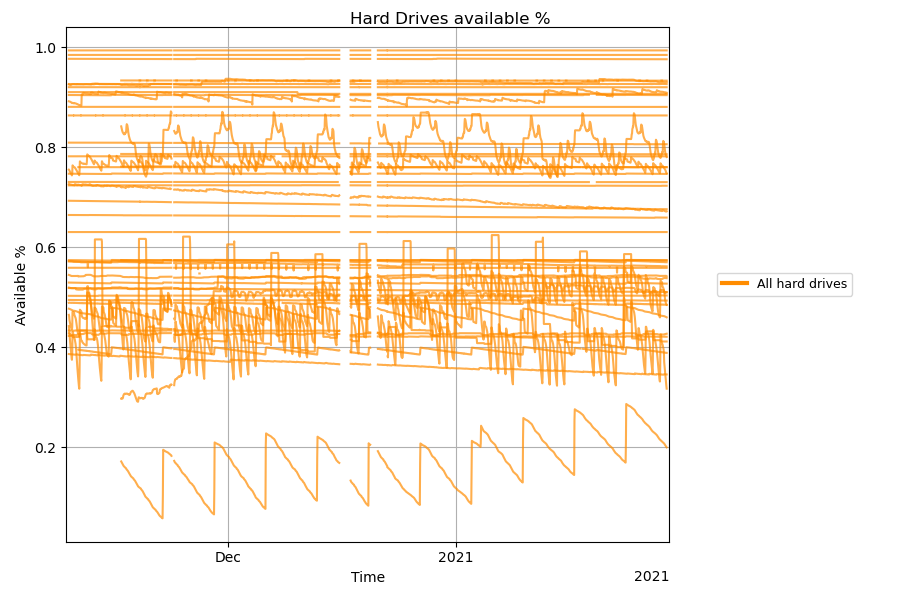

In [20]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = df_hourly[start:end]


# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs


for col in df_plot.columns:

    pax.plot(df_plot.index, df_plot[col], label=col,
         color="darkorange", linewidth=1.5, alpha=0.7)
    

# pax.plot(df_plot.index, df_plot["rol_mean_day"], label="Rolling Mean Day",
#         color="blue", linewidth=1.5)
# pax.plot(df_plot.index, df_plot["rol_mean_week"], label="Rolling Mean Week",
#         color="red", linewidth=1.5)

# pax.plot(df_plot.index, df_plot["rol_std_day"], label="Rolling Std Day",
#         color="black", linewidth=1.5)

#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
#month_fmt = mdates.DateFormatter('%m')
month_fmt = mdates.ConciseDateFormatter('%Y-%m')

# format the ticks
pax.xaxis.set_major_locator(months)
pax.xaxis.set_major_formatter(month_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'D')
datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
pax.set_xlim(datemin, datemax)


pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Time")
lax.axis('off')


line = [Line2D([0], [0], color="darkorange", linewidth=3, linestyle='-')]
label = ['All hard drives']
lax.legend(line, label, loc=10, fontsize=9)

# lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Hard Drives available %")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])




Il est intéressant de voir sur le graphe ci-dessus l'évolution des différents disques. En effet, on remarque que certains ont un comportement saisonnier comme celui présent tout en bas du graphique. D'autres semblent avoir une tendance négative et voient leur espace de stockage diminuer tandis que d'autres semblent avoir un niveau constant.

On note également l'hétérogénéité des disques qui semblent avoir chacun une évolution propre même s'il semblerait que certains d'entre eux ont un espace disponible qui évolue en dent de scie ce qui pourrait correspondre à des épurations périodiques des serveurs.

On remarque également la présence d'une bande blanche au milieu de nos données représentant un nombre important de valeurs manquantes pour l'intégralité des disques durs. Ces deux trous dans les données sont apparus entre les 16 et 17 décembre ainsi qu'entre le 20 et 21 décembre.

Il est possible que d'autres valeurs manquantes soient présentes dans le jeu de données. Pour pouvoir les observer nous allons nous aider du module missingno qui mettra en évidence les Nans présents dans notre jeu de données.

### Premiers  Visuels

<IPython.core.display.Javascript object>


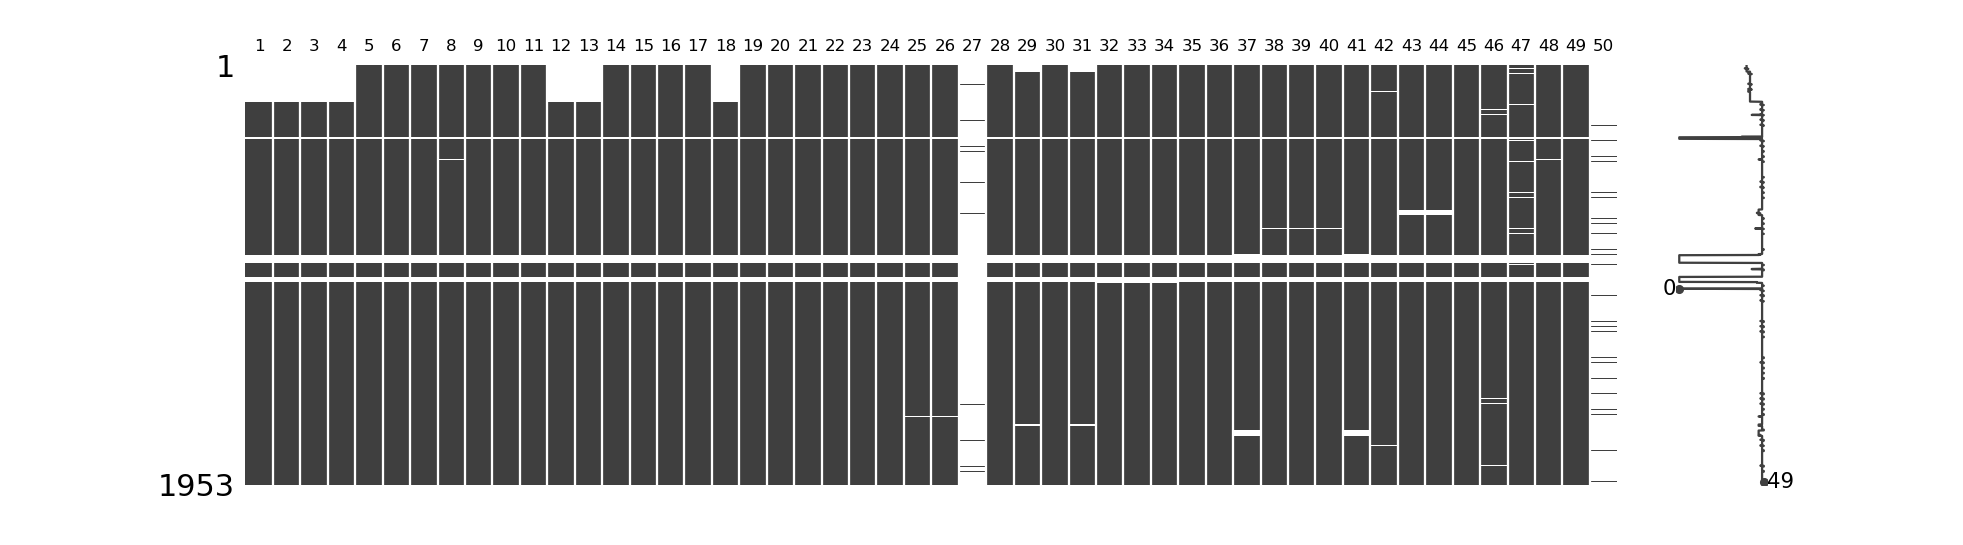

In [13]:
m = msno.matrix(df_hourly, figsize=(18, 5))


# get ticks names and positions
cols = [i.get_text() for i in m.axes.get_xticklabels()]
ticks = np.arange(0,len(cols))
# plot new ticks
plt.xticks(ticks, labels=ticks+1, rotation=0, ha='center', fontsize=11)# title n plot
plt.title('Null values matrix\n'.upper(), loc='center', fontsize=22)
plt.show()

Effectivement, au milieu de notre jeu de données nous avons des valeurs manquantes pour l'ensemble de nos disques durs. On remarque aussi qu'il y a eu un autre trou dans nos données le 23 novembre, ce qui n'était pas visible sur notre graphe précédent. Nous verrons plus tard comment nous allons traiter ces défauts.

On observe également des valeurs manquantes au début de notre jeu de données pour les disques 1 à 4, 12, 13 et dans une moindre mesure pour les disques 18,29 et 31.


Nous relevons aussi des valeurs manquantes qui apparaissent de manière assez aléatoire pour certains groupes de disques comme par exemple pour les disques 37 et 47, les disques 29 et 31 ou encore les disques 38, 39, 40. Ces groupes correspondent peut-être à des client en particuier où un défaut serait apparu. Il pourrait être intéressant de rajouter une colonne renseignant sur le client correspondant pour pouvoir faire une analyse plus poussée de nos données et savoir quels disques durs sont sur la même machine.

Enfin, il est important de noter une très faible quantité de données pour les disques 27 et 50. Etant donné le nombre élevé de valeurs manquantes présentes pour ces deux disques, nous allons les retirer de notre jeu de données lors de la suite du projet.

Voici ci-dessous d'autres graphes utiles mettant en évidence la présence de Nans dans notre jeu de données.


<IPython.core.display.Javascript object>


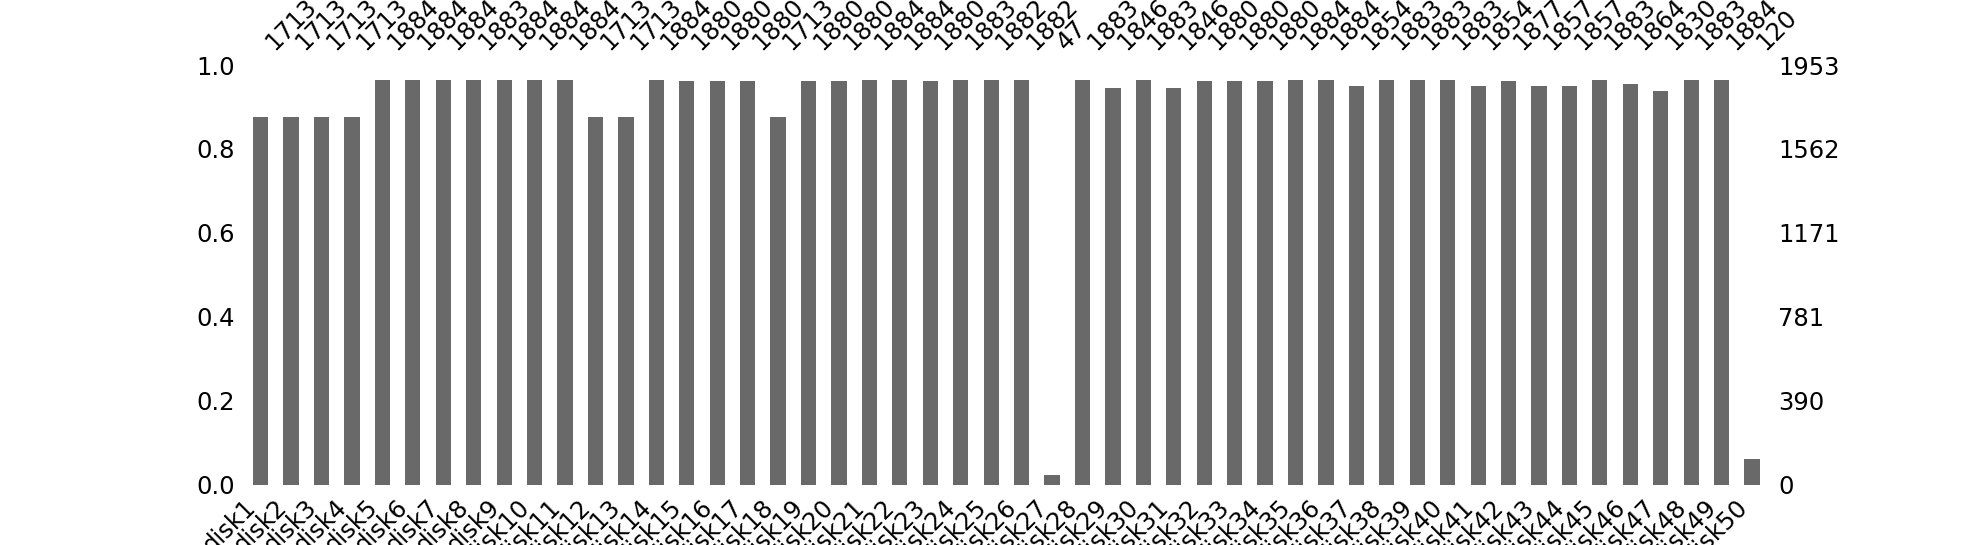

In [15]:
# Proportion of present values in the dataset
plt.figure()
msno.bar(df_hourly, figsize=(18, 5))

In [14]:
# We are not dropping these columns now because we will still do analysis.
# We will be dropping them in the Statistical Analysis part
# df_hourly.drop(columns=['disk27', 'disk50'], inplace=True)

<IPython.core.display.Javascript object>


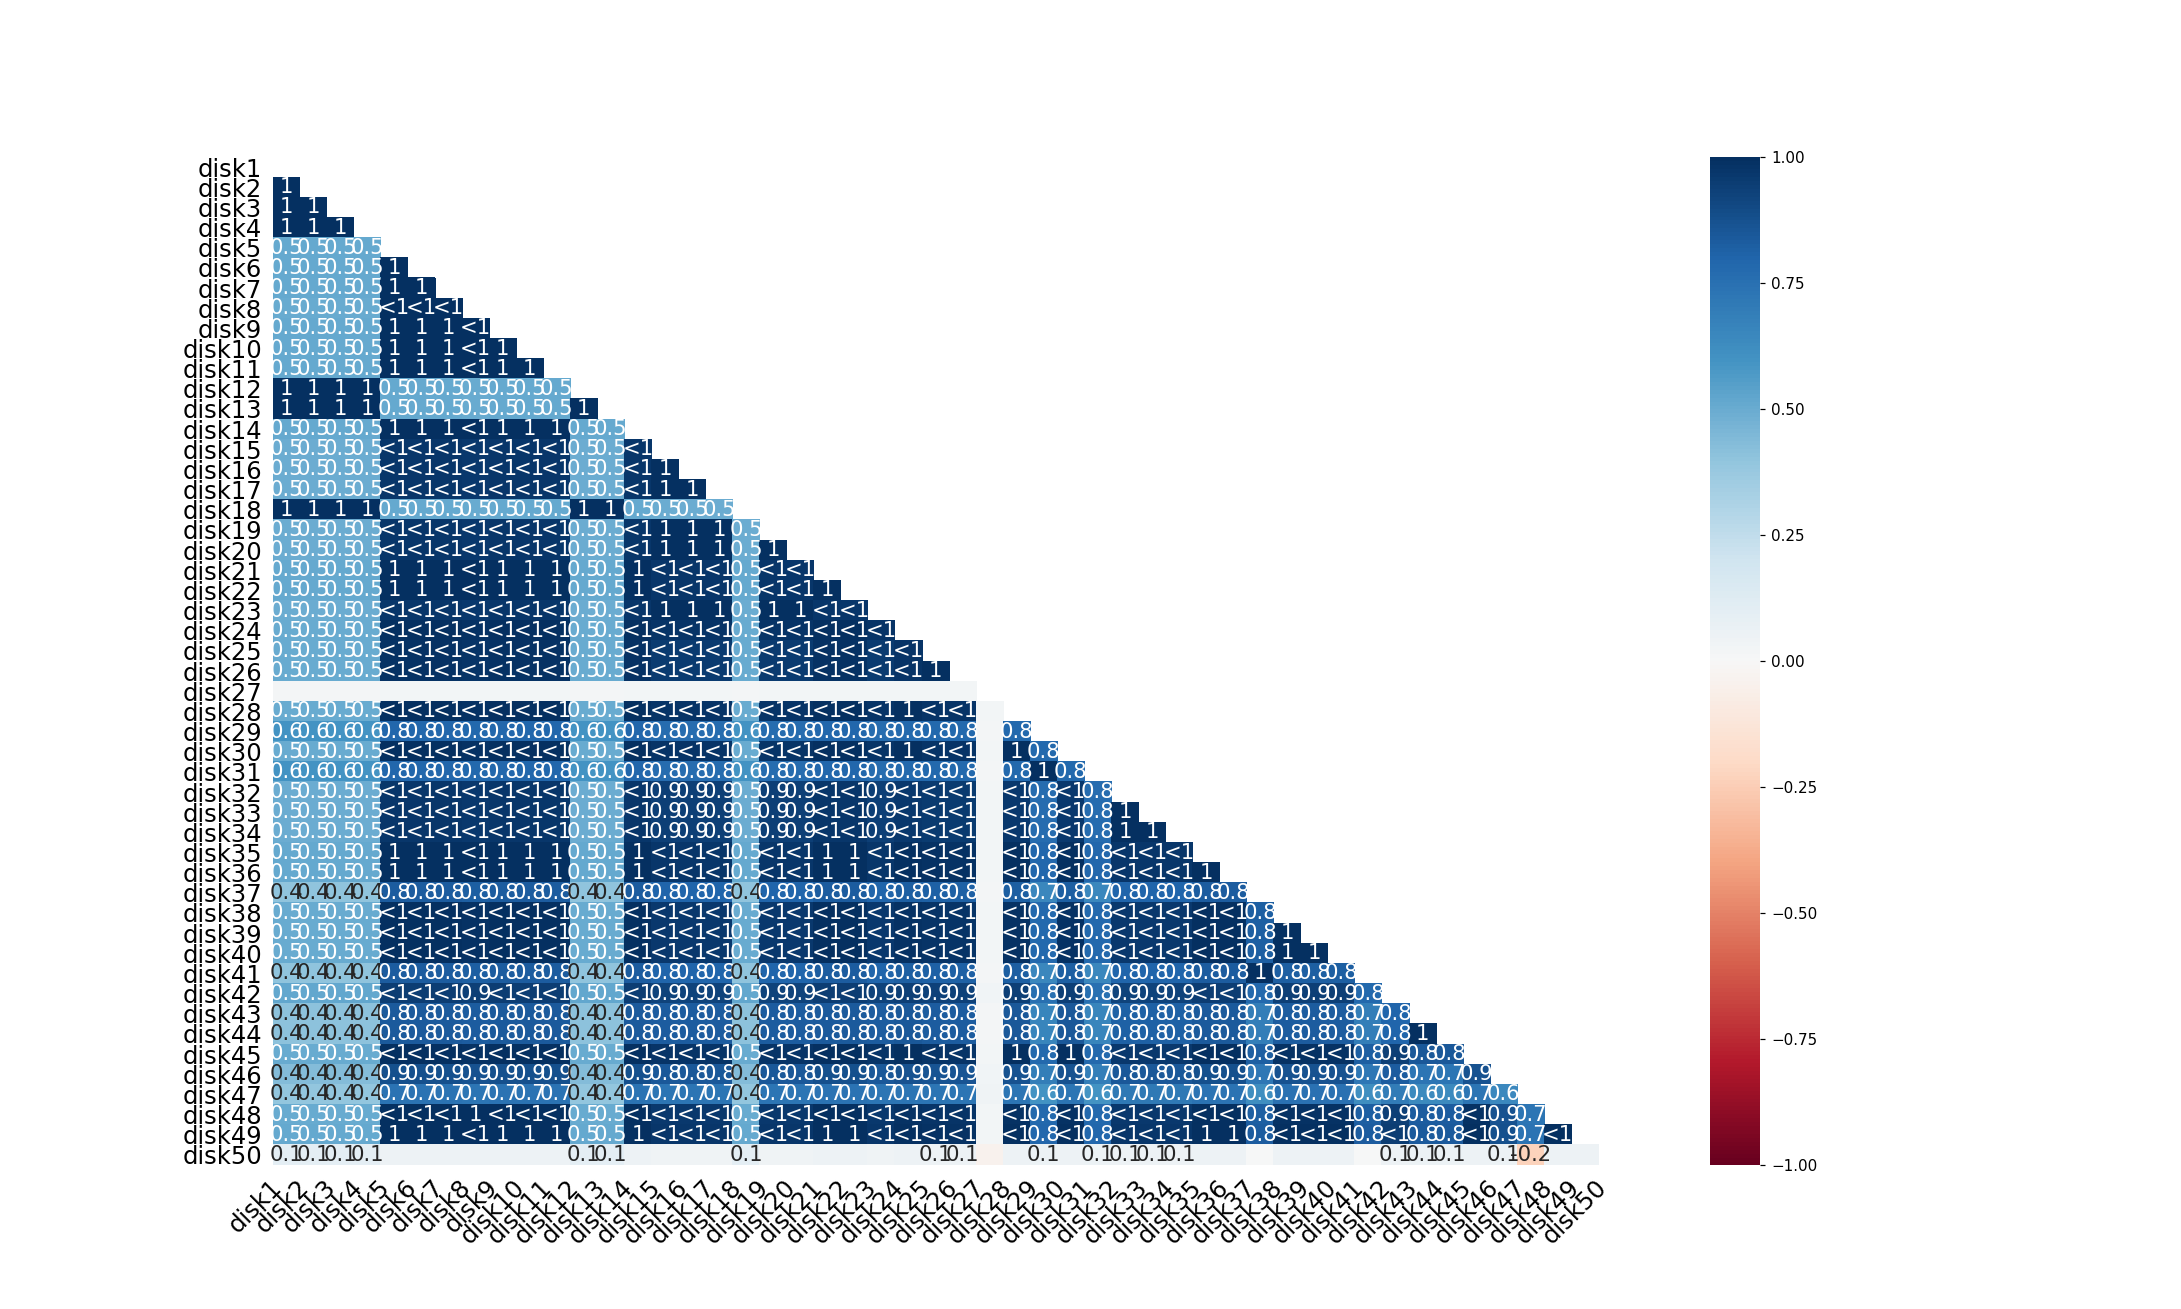

In [16]:
# correlation with Nans occurences between different disks
msno.heatmap(df_hourly)

Le graphe ci-dessus peut être utile pour identifier les disques durs présents chez un même client.

Dans la continuité de notre analyse nous allons tracer chacune des évolutions de disques durs sur un graphe à part. Nous allons d'abord tous les mettre à une échelle comprise entre 0 et 1 et allons ensuite adapter l'échelle de chacun des graphes à l'évolution du disque considéré.

<IPython.core.display.Javascript object>


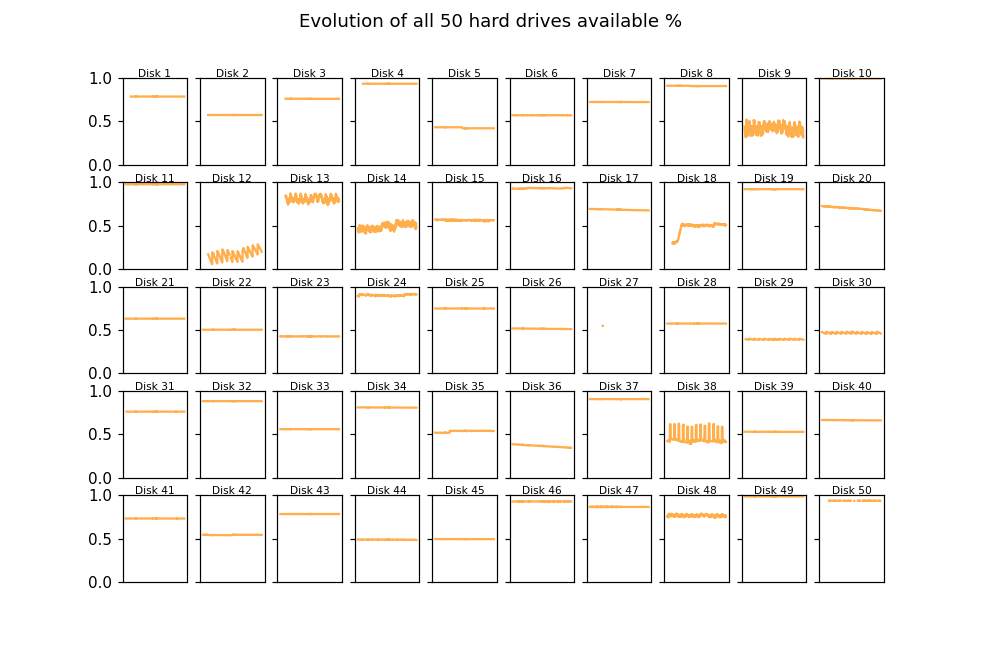

Text(0.5, 0.98, 'Evolution of all 50 hard drives available %')

In [21]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = df_hourly[start:end].copy()

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(5, 10, sharex=True, 
                        sharey=True,
                        figsize=(9, 6))



for i in range(5):
    pax1, pax2, pax3, pax4, pax5, pax6, pax7, pax8, pax9, pax10 = axs[i]
    
    pax1.plot(df_plot.index, df_plot[df_plot.columns[i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax1.set_ylim(bottom=0, top=1)
    # pax1.set_title('d {%d}', fontsize=2)
    pax1.set_title('Disk {}'.format(i*10+1), fontsize=7, pad=0.5)
    
    pax2.plot(df_plot.index, df_plot[df_plot.columns[1+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax2.set_title('Disk {}'.format(i*10+2), fontsize=7, pad=0.5)

    
    pax2.set_ylim(bottom=0, top=1)

    pax3.plot(df_plot.index, df_plot[df_plot.columns[2+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax3.set_ylim(bottom=0, top=1)
    pax3.set_title('Disk {}'.format(i*10+3), fontsize=7, pad=0.5)

    
    
    pax4.plot(df_plot.index, df_plot[df_plot.columns[3+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax4.set_ylim(bottom=0, top=1)
    pax4.set_title('Disk {}'.format(i*10+4), fontsize=7, pad=0.5)

    
    pax5.plot(df_plot.index, df_plot[df_plot.columns[4+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax5.set_ylim(bottom=0, top=1)
    pax5.set_title('Disk {}'.format(i*10+5), fontsize=7, pad=0.5)
    
    
    pax6.plot(df_plot.index, df_plot[df_plot.columns[5+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax6.set_ylim(bottom=0, top=1)
    pax6.set_title('Disk {}'.format(i*10+6), fontsize=7, pad=0.5)
    
    
    pax7.plot(df_plot.index, df_plot[df_plot.columns[6+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax7.set_ylim(bottom=0, top=1)
    pax7.set_title('Disk {}'.format(i*10+7), fontsize=7, pad=0.5)

    
    pax8.plot(df_plot.index, df_plot[df_plot.columns[7+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax8.set_ylim(bottom=0, top=1)
    pax8.set_title('Disk {}'.format(i*10+8), fontsize=7, pad=0.5)

    
    pax9.plot(df_plot.index, df_plot[df_plot.columns[8+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax9.set_ylim(bottom=0, top=1)
    pax9.set_title('Disk {}'.format(i*10+9), fontsize=7, pad=0.5)

    
    pax10.plot(df_plot.index, df_plot[df_plot.columns[9+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.7)
    pax10.set_ylim(bottom=0, top=1)
    pax10.set_title('Disk {}'.format(i*10+10), fontsize=7, pad=0.5)
    
    
    
    
    for j, pax in enumerate(axs[i]):
        pax.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
        
        if j != 0:
            pax.tick_params(axis='y',         
                            which='both',      
                            labelleft=False)
        
        
fig.suptitle('Evolution of all 50 hard drives available %')


Le graphe ci-dessus permet de mettre en évidence les différentes évolutions de chacun des disques durs. On remarque bien que certains ont une saisonnalité très prononcée avec des variations d'amplitudes très élevées tandis que d'autres semblent avoir une variation monotone qui est constante ou nulle. Mais cela est-il vraiment le cas?
Adaptons dorénavant l'échelle à chacun des signaux .

<IPython.core.display.Javascript object>


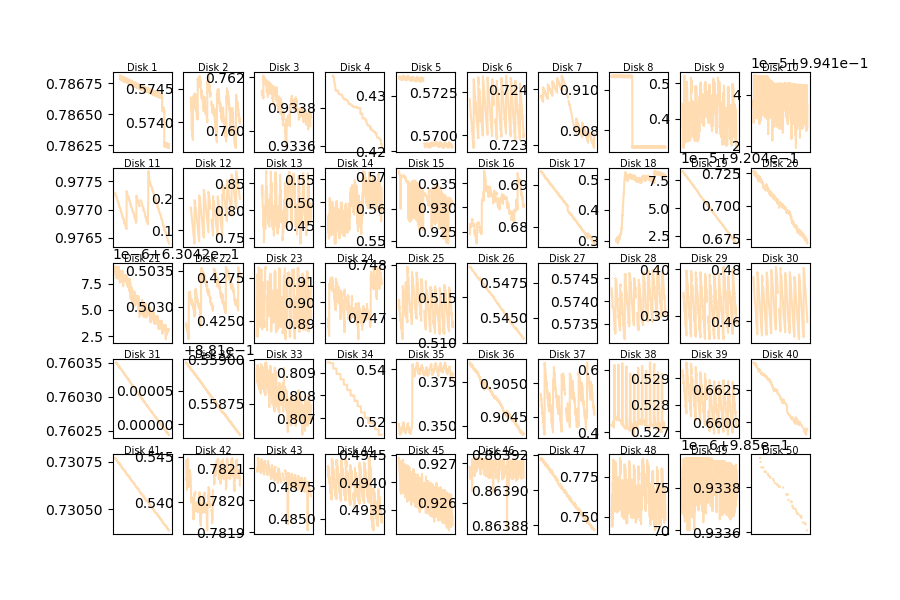

In [22]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = df_hourly[start:end].copy()

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(5, 10, sharex=True,
                        figsize=(9, 6))



for i in range(5):
    pax1, pax2, pax3, pax4, pax5, pax6, pax7, pax8, pax9, pax10 = axs[i]
    
    pax1.plot(df_plot.index, df_plot[df_plot.columns[i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax1.set_title('Disk {}'.format(i*10+1), fontsize=7, pad=0.5)

    
    pax2.plot(df_plot.index, df_plot[df_plot.columns[1+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax2.set_title('Disk {}'.format(i*10+2), fontsize=7, pad=0.5)

    
    pax3.plot(df_plot.index, df_plot[df_plot.columns[2+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax3.set_title('Disk {}'.format(i*10+3), fontsize=7, pad=0.5)


    pax4.plot(df_plot.index, df_plot[df_plot.columns[3+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax4.set_title('Disk {}'.format(i*10+4), fontsize=7, pad=0.5)
    
    pax5.plot(df_plot.index, df_plot[df_plot.columns[4+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax5.set_title('Disk {}'.format(i*10+5), fontsize=7, pad=0.5)
    
    pax6.plot(df_plot.index, df_plot[df_plot.columns[5+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax6.set_title('Disk {}'.format(i*10+6), fontsize=7, pad=0.5)

    
    pax7.plot(df_plot.index, df_plot[df_plot.columns[6+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax7.set_title('Disk {}'.format(i*10+7), fontsize=7, pad=0.5)

    
    pax8.plot(df_plot.index, df_plot[df_plot.columns[7+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax8.set_title('Disk {}'.format(i*10+8), fontsize=7, pad=0.5)


    pax9.plot(df_plot.index, df_plot[df_plot.columns[8+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)
    pax9.set_title('Disk {}'.format(i*10+9), fontsize=7, pad=0.5)

    
    pax10.plot(df_plot.index, df_plot[df_plot.columns[9+i*10]],
              color="darkorange", linewidth=1.5, alpha=0.3)    
    pax10.set_title('Disk {}'.format(i*10+10), fontsize=7, pad=0.5)

    
    
    
    for j, pax in enumerate(axs[i]):
        pax.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off

Ce graphe met en évidence l'évolution de chacun des disques et permet de montrer des comportements qui n'étaient pas visibles dans le graphique précédent. En effet, si on s'attarde sur le disque 6, on remarque qu'il a une saisonnalité alors qu'il semblait constant sur le graphique précédent. Il en est de même pour le disque 34 par exemple où l'on remarque une tendance négative sur le signal. La particularité de ces disques est qu'ils varient de manière très faible autour d'une valeur ce qui empêche de voir la saisonalité ou encore la tendance négative. Cette première analyse nous confirme donc bien les différentes évolutions que peuvent avoir les disque durs.

Nous nous sommes également proposés de tracer les distributions des différents disques et nous remarquons que certains ont une distribution normale. Cela dit, nous n'avons pas eu le temps de mettre ce graphique en forme en choisissant le bon nombre de bins. Nous comptons sur le prochain contributeur du projet pour continuer améliorer la mise en forme de ce graphe. 

<IPython.core.display.Javascript object>


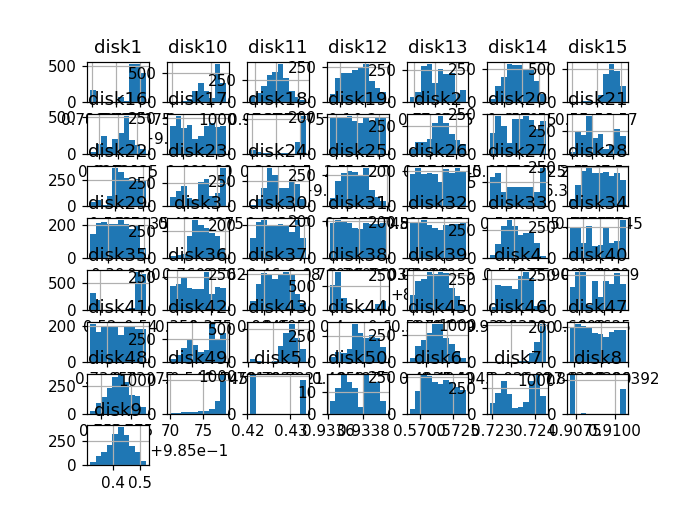

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026D5315ADA0>,
      dtype=object)

In [22]:
df_hourly.hist()

Enfin pour finir notre première analyse visuelle des évolutions de disques durs, nous avons tracé la matrice de corrélation des disques. Comme nous le verrons ci-dessous, la quantité de disques ne permet pas d'avoir une répartiton bien discernable à l'oeil nu lors d'un plot simple, même s'il est indéniable que certaines évolutions de disques durs sont très corrélées entre-elles. Dans la mesure où nous voulons par la suite clusteriser des groupes de disques durs, il est rassurant de voir que certains coefficients de corrélation (Pearson) sont égales ou très proches de 1 comme nous l'indique la figure ci-dessous.

<IPython.core.display.Javascript object>


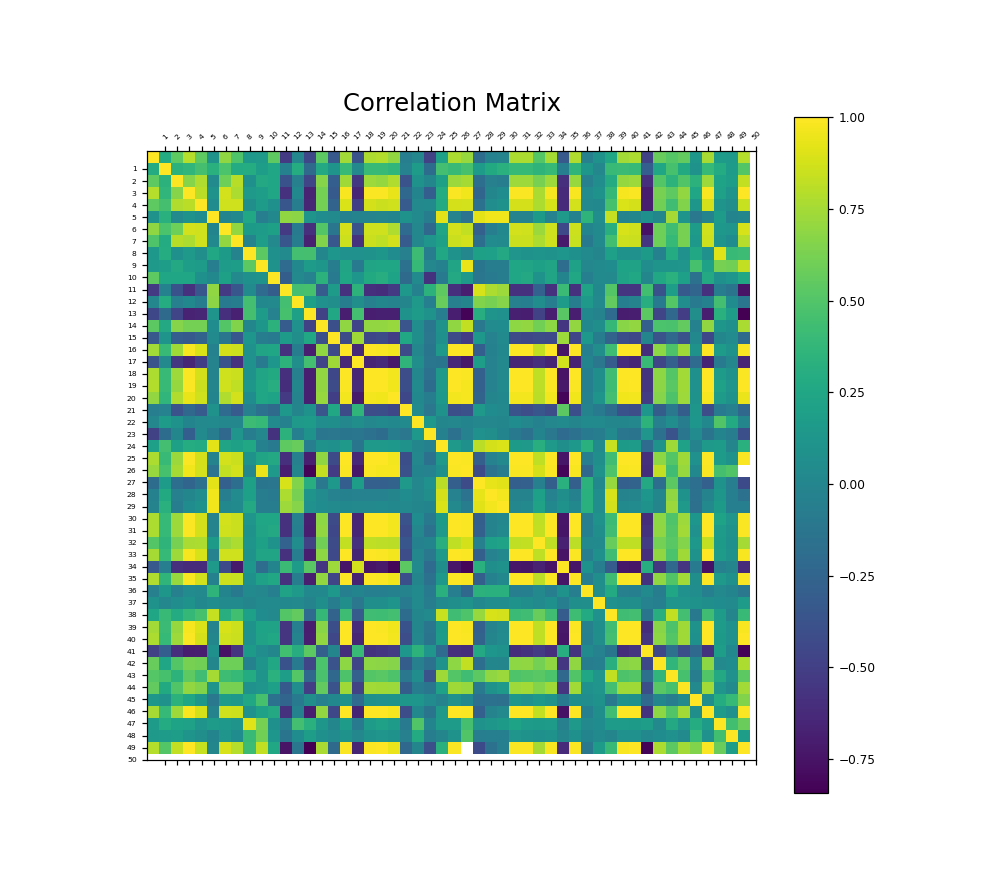

In [23]:
f = plt.figure(figsize=(9, 8))
plt.matshow(df_hourly.corr(), fignum=f.number)
plt.xticks(range(1, 51), fontsize=5, rotation=45)
plt.yticks(range(1, 51), fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=16);

## Analyse au pas de temps quotidien

 On se propose maintenant une petite observation des signaux au pas de temps quotidien. Pour cela nous effectuons un resampling de nos données.

In [23]:
# Resampling data daily
df_daily = df_hourly.resample('D').mean()

<IPython.core.display.Javascript object>


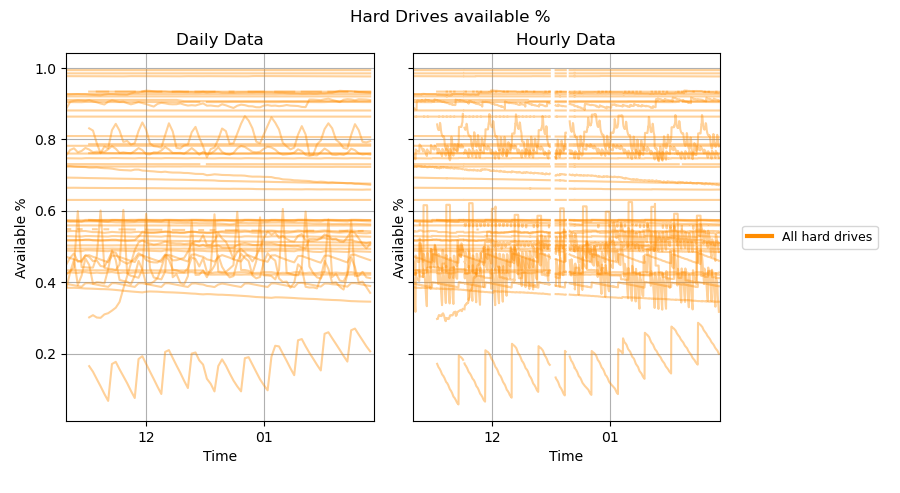

In [26]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = df_daily[start:end]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 3, sharex=True, 
                        sharey=True,
                        figsize=(9, 4),
                        gridspec_kw={"width_ratios": [3, 3, 1]})


pax_d, pax_h, _ = axs

pax_d.title.set_text('Daily Data')
pax_h.title.set_text('Hourly Data')

for col in df_plot.columns:

    pax_d.plot(df_plot.index, df_plot[col], label=col,
         color="darkorange", linewidth=1.5, alpha=0.4)
    pax_h.plot(df_hourly.index, df_hourly[col], label=col,
         color="darkorange", linewidth=1.5, alpha=0.4)
    

# pax.plot(df_plot.index, df_plot["rol_mean_day"], label="Rolling Mean Day",
#         color="blue", linewidth=1.5)
# pax.plot(df_plot.index, df_plot["rol_mean_week"], label="Rolling Mean Week",
#         color="red", linewidth=1.5)

# pax.plot(df_plot.index, df_plot["rol_std_day"], label="Rolling Std Day",
#         color="black", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')


for pax in axs[:-1]:
# format the ticks
    pax.xaxis.set_major_locator(months)
    pax.xaxis.set_major_formatter(month_fmt)
    # pax.xaxis.set_minor_locator(months)
    pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    pax.grid(True)

    datemin = np.datetime64(df_plot.index[0], 'D')
    datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
    pax.set_xlim(datemin, datemax)
    pax.set_ylabel("Available %")
    pax.set_xlabel("Time")


lax = axs[-1]
lax.axis('off') 


line = [Line2D([0], [0], color="darkorange", linewidth=3, linestyle='-')]
label = ['All hard drives']
lax.legend(line, label, loc=10, fontsize=9)

# lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Hard Drives available %")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


On remarque que le resampling permet de lisser la courbe et de mettre en évidence la tendance des données. Elle permet aussi de combler certaines des valeurs manquantes présentes dans notre jeu de données.
Cela dit, elle enlève la saisonnalité des signaux ayant de faibles variations.
Nous allons pour l'instant continuer à travailler avec des valeurs au pas de temps horaire et verrons dans la partie prédictions s'il est pertinent ou non de travailler avec les données au pas de temps quotidien. 

### Analyse des vitesse de consommation

Pour terminer notre première analyse, nous allons créer une dataframe comportant les dérivées de chacun des disques qui vont nous renseigner sur la vitesse de remplissage. Ces informations peuvent s'avérer utiles si nous réalisons un cluster groupant les disques durs qui ont des vitesses de consommations similaires.

In [25]:
df_derive = df_hourly.diff() # Differencing with lag 1

In [26]:
df_derive.head()

disk1  disk2  disk3  disk4     disk5     disk6  \
2020-11-09 08:00:00    NaN    NaN    NaN    NaN       NaN       NaN   
2020-11-09 09:00:00    NaN    NaN    NaN    NaN -0.000020 -0.000021   
2020-11-09 10:00:00    NaN    NaN    NaN    NaN -0.000026 -0.000034   
2020-11-09 11:00:00    NaN    NaN    NaN    NaN -0.000021 -0.000042   
2020-11-09 12:00:00    NaN    NaN    NaN    NaN -0.000028 -0.000038   

                            disk7     disk8     disk9        disk10  ...  \
2020-11-09 08:00:00           NaN       NaN       NaN           NaN  ...   
2020-11-09 09:00:00 -9.688766e-07 -0.000004 -0.005202  1.558479e-06  ...   
2020-11-09 10:00:00 -1.957131e-06  0.000076 -0.011045  1.151366e-06  ...   
2020-11-09 11:00:00 -1.401641e-06 -0.000006 -0.007100 -1.914703e-06  ...   
2020-11-09 12:00:00 -1.469463e-06 -0.000006 -0.007843 -2.226399e-07  ...   

                           disk41    disk42        disk43    disk44    disk45  \
2020-11-09 08:00:00           NaN       NaN           NaN       NaN       NaN   
2020-11-09 09:00:00  1.110223e-16 -0.000196 -9.650169e-06  0.000226 -0.000007   
2020-11-09 10:00:00  0.000000e+00 -0.000323 -2.297659e-07 -0.000092 -0.000010   
2020-11-09 11:00:00  0.000000e+00 -0.000101 -3.063546e-07 -0.000180 -0.000011   
2020-11-09 12:00:00  0.000000e+00 -0.000315  2.680603e-07  0.000215 -0.000012   

                       disk46        disk47    disk48    disk49  disk50  
2020-11-09 08:00:00       NaN           NaN       NaN       NaN     NaN  
2020-11-09 09:00:00  0.000008  5.361205e-07 -0.000696 -0.000004     NaN  
2020-11-09 10:00:00 -0.000044 -7.658865e-08 -0.001239  0.000003     NaN  
2020-11-09 11:00:00 -0.000016  7.658865e-08 -0.001209 -0.000002     NaN  
2020-11-09 12:00:00 -0.000055  0.000000e+00 -0.001297  0.000003     NaN  

[5 rows x 50 columns]

Plot de derivee

<IPython.core.display.Javascript object>


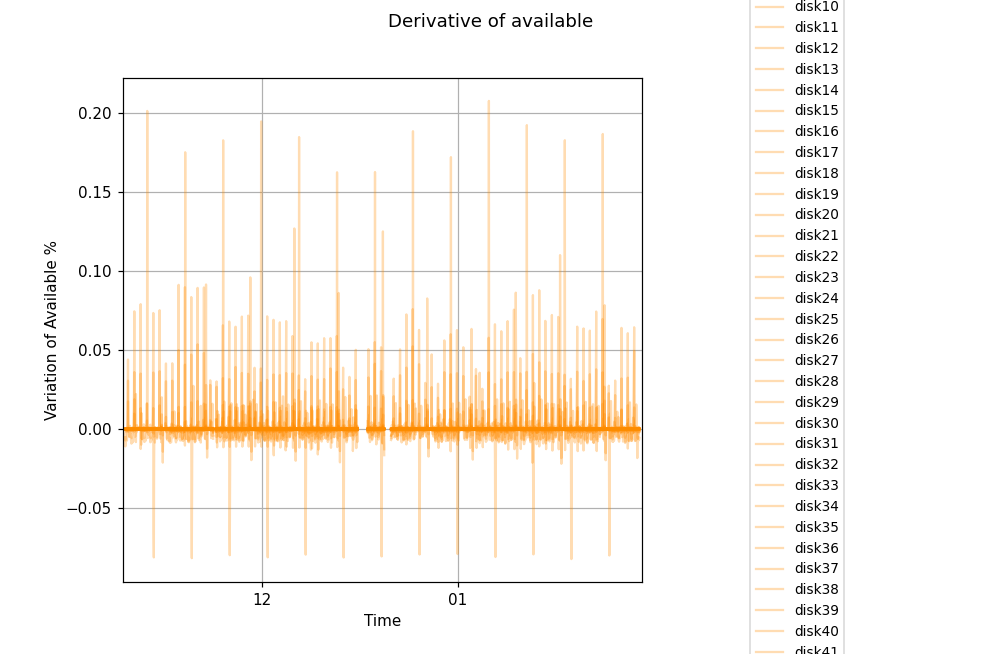

Text(0.5, 0.98, 'Derivative of available')

In [27]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = df_derive[start:end]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs

for col in df_plot.columns:

    pax.plot(df_plot.index, df_plot[col], label=col,
         color="darkorange", linewidth=1.5, alpha=0.3)
    

# pax.plot(df_plot.index, df_plot["rol_mean_day"], label="Rolling Mean Day",
#         color="blue", linewidth=1.5)
# pax.plot(df_plot.index, df_plot["rol_mean_week"], label="Rolling Mean Week",
#         color="red", linewidth=1.5)

# pax.plot(df_plot.index, df_plot["rol_std_day"], label="Rolling Std Day",
#         color="black", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')

# format the ticks
pax.xaxis.set_major_locator(months)
pax.xaxis.set_major_formatter(month_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'D')
datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Variation of Available %")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Derivative of available")
# fig.suptitle("From {} to {})".format(start, end))
# fig.tight_layout(rect=[0,0,1,0.98])

L'analyse est difficile à réaliser au pas de temps horaire, on propose donc de passer à un pas de temps quotidien. On va réaliser cela en faisant un resampling de la dataframe resamplée précedemment.

In [30]:
df_daily_d = df_daily.diff()

<IPython.core.display.Javascript object>


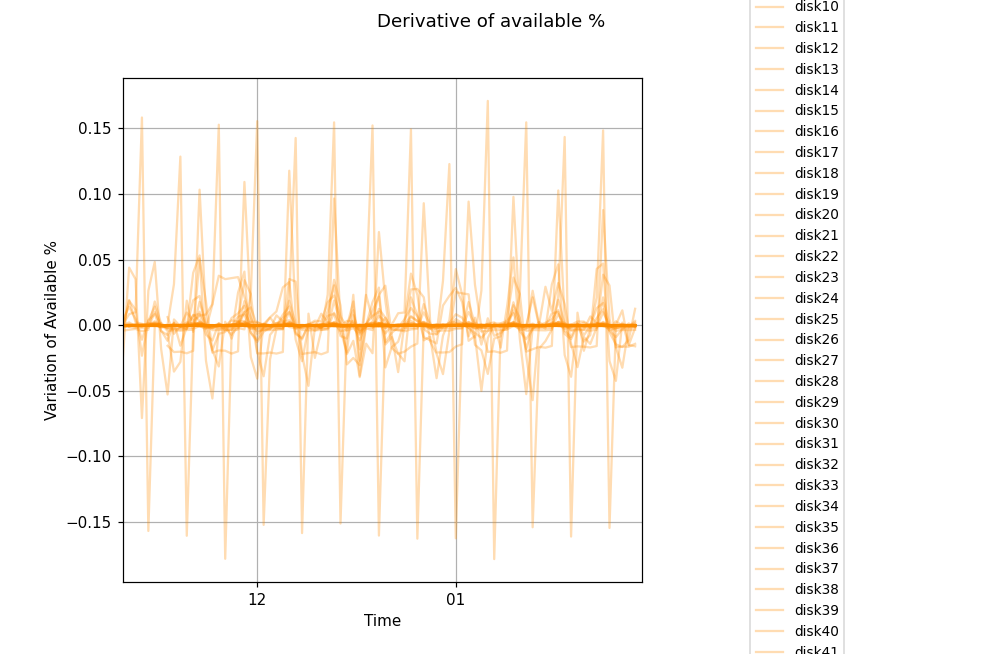

Text(0.5, 0.98, 'Derivative of available %')

In [31]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = df_daily_d[start:end]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs

for col in df_plot.columns:

    pax.plot(df_plot.index, df_plot[col], label=col,
         color="darkorange", linewidth=1.5, alpha=0.3)
    

# pax.plot(df_plot.index, df_plot["rol_mean_day"], label="Rolling Mean Day",
#         color="blue", linewidth=1.5)
# pax.plot(df_plot.index, df_plot["rol_mean_week"], label="Rolling Mean Week",
#         color="red", linewidth=1.5)

# pax.plot(df_plot.index, df_plot["rol_std_day"], label="Rolling Std Day",
#         color="black", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')

# format the ticks
pax.xaxis.set_major_locator(months)
pax.xaxis.set_major_formatter(month_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'D')
datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Variation of Available %")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------


fig.suptitle("Derivative of available %")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

Encore une fois il est difficile d'analyser ce graphe. Cela dit, des informations telle que la moyenne, la mediane ou encore l'écart-type sont des features intéressante pour la réalisation de clusters.

## Calcul d'indicateurs Statistiques

Maintenant que nous avons prétraité nos données, nous passons à la partie où nous nous intéressons au calcul d'indicateurs statistiques. Il est important de noter que ces indicateurs vont nous permettre de classifier nos données en fonction de méthodes de similarités que nous allons choisir à posteriori. 

Tout d'abord on enlève les données concernant les disques 27 et 50 car nous avons constaté dans la partie précédante qu'il manque la majorité des données pour ces disques. La classification peut être érronée à cause de ces deux colonnes qui ne sont par représentatives de notre population.  

In [32]:
df_hourly.drop(columns=['disk27', 'disk50'], inplace=True) # Dropping columns 50 and 27

### Test de tendance

Le premier indicateur que nous avons décidé d'analyser est la présence de tendance ou non qui nous indiquera si un disque voit son espace de stockage augmenter, diminuer ou reste inchangé au cours du temps. 
Cette caractéristique nous pouvons l'observer à l'aide du test de tendance de Mann-Kendall. 

L'algorithme que nous mettons en place consiste à parcourir toutes les colonnes (donc tous les disques à part le 27 et le 50 qui ont été préalablement enlévés du jeu de données) afin de trouver le type de tendance présente dans chaque disque. 

L'implementation du test de tendance de Mann-Kendall sous-entend que dans le jeu de données il n'y a pas de valeurs NaN. 
Afin de pallier à ce problème nous faisons des intérpolations linéaires (avec la fonction interpolate de pandas) aux endroits où il est nécessaire de combler les valeurs manquantes. Si les valeurs manquantes se situent au tout début de la colonne, nous utilisions la fonction BeforeFill qui comble la valeur manquante avec la première valeur connue pour le disque concerné.  

La deuxième étape consiste à décomposer chaque signal en une partie nous renseignant sur la saisonnalité du signal et une autre sur sa tendance. Une fois la décomposition réalisée, nous retirons le signal saisonnier du signal complet pour n'avoir accés qu'à la partie donnant l'information sur la tendance du signal. 
La sortie du test nous donne la p-value et le type de tendance présente dans le signal (montante, descendante ou sans tendance).

In [36]:
# Remove Nans to apply statistics tests
trend_df = df_hourly.interpolate()
trend_df.fillna(method='bfill', inplace=True)

no_trend_df = trend_df.copy()

# Creating dictionary for each statistic test
test_tab = ['trend', 'seasonality'] # Add element to this list for additional test
dic_features = {col:dict.fromkeys(test_tab) for col in trend_df.columns.tolist()}
for col in trend_df.columns:
    pmk_series = trend_df[col] - seasonal_decompose(trend_df[col]).seasonal
    test = pmk.hamed_rao_modification_test(pmk_series, alpha=0.05) # Test that deals with autocorrelation
    print(col, ':', test.trend)
    dic_features[col]['trend'] = {}
    dic_features[col]['trend']['test'] = test.trend
    dic_features[col]['trend']['p_value'] = test.p
    
    no_trend_df[col] = no_trend_df[col] - seasonal_decompose(no_trend_df[col]).trend
    

disk1 : decreasing
disk2 : decreasing
disk3 : decreasing
disk4 : decreasing
disk5 : decreasing
disk6 : no trend
disk7 : decreasing
disk8 : decreasing
disk9 : no trend
disk10 : decreasing
disk11 : no trend
disk12 : increasing
disk13 : no trend
disk14 : increasing
disk15 : decreasing
disk16 : no trend
disk17 : decreasing
disk18 : increasing
disk19 : decreasing
disk20 : decreasing
disk21 : decreasing
disk22 : no trend
disk23 : no trend
disk24 : no trend
disk25 : decreasing
disk26 : decreasing
disk28 : increasing
disk29 : no trend
disk30 : no trend
disk31 : decreasing
disk32 : decreasing
disk33 : decreasing
disk34 : decreasing
disk35 : no trend
disk36 : decreasing
disk37 : no trend
disk38 : decreasing
disk39 : decreasing
disk40 : decreasing
disk41 : decreasing
disk42 : increasing
disk43 : decreasing
disk44 : decreasing
disk45 : decreasing
disk46 : decreasing
disk47 : decreasing
disk48 : decreasing
disk49 : decreasing


Le graphe ci-dessous, nous donne une classification des signaux en fonction de leur tendance. 

<IPython.core.display.Javascript object>


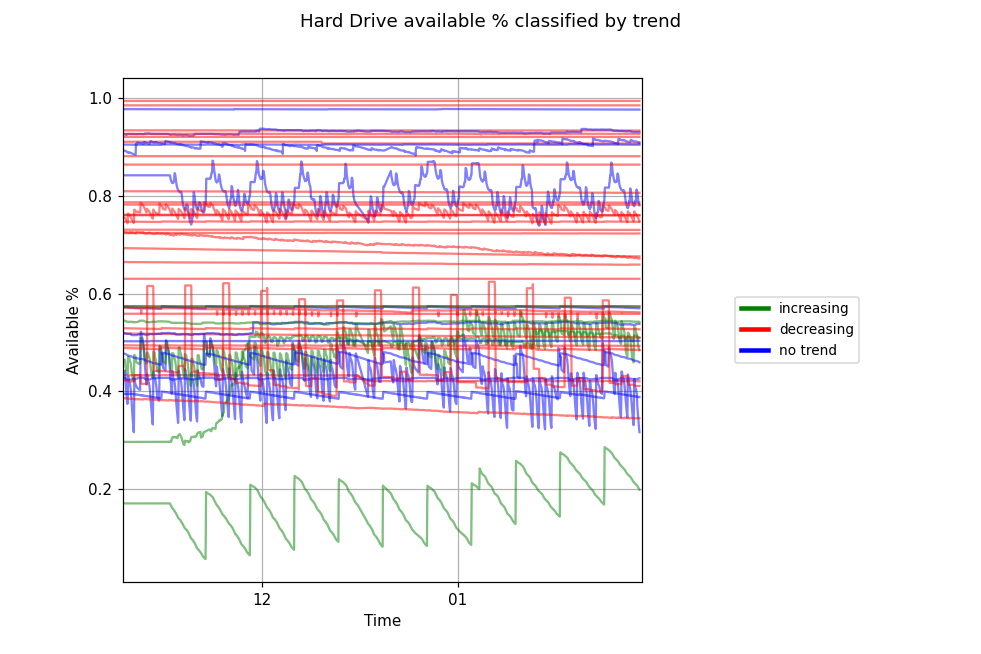

Text(0.5, 0.98, 'Hard Drive available % classified by trend')

In [37]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = trend_df

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})



dic_color = {'increasing':'green', 'decreasing':'red', 'no trend':'blue'}
pax, _ = axs

for col in df_plot.columns:

    pax.plot(df_plot.index, df_plot[col], label=col,
         color=dic_color[dic_features[col]['trend']['test']], 
             linewidth=1.5, alpha=0.5)
    
    
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')

# format the ticks
pax.xaxis.set_major_locator(months)
pax.xaxis.set_major_formatter(month_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'D')
datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Time")

lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
labels = ['increasing', 'decreasing', 'no trend']
lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Hard Drive available % classified by trend")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

Il est intéressant de remarquer que seulement 10.42% de tous les disques ont une tendance à la hausse, 64.58% ont une tendance à la baisse et 25% ne représente aucune tendance. C'est tout à fait normal, parce que nous pouvons remarquer que la majorité des disques voient leurs espaces de stockage diminuner avec le temps et se remplir de plus en plus. D'où l'intérêt de notre étude.

In [38]:
increasing_disk = [v for i, v in enumerate(dic_features.keys()) if  dic_features[v]['trend']['test'] == 'increasing']

print('Disks with increasing trend represent {:.2f} % of total disks'.format(100*len(increasing_disk)/len(dic_features.keys())))

decreasing_disk = [v for i, v in enumerate(dic_features.keys()) if  dic_features[v]['trend']['test'] == 'decreasing']
print('Disks with decreasing trend represent {:.2f} % of total disks'.format(100*len(decreasing_disk)/len(dic_features.keys())))


no_trend_disk = [v for i, v in enumerate(dic_features.keys()) if  dic_features[v]['trend']['test'] == 'no trend']
print('Disks with no trend represent {:.2f} % of total disks'.format(100*len(no_trend_disk)/len(dic_features.keys())))


Disks with increasing trend represent 10.42 % of total disks
Disks with decreasing trend represent 64.58 % of total disks
Disks with no trend represent 25.00 % of total disks


<IPython.core.display.Javascript object>


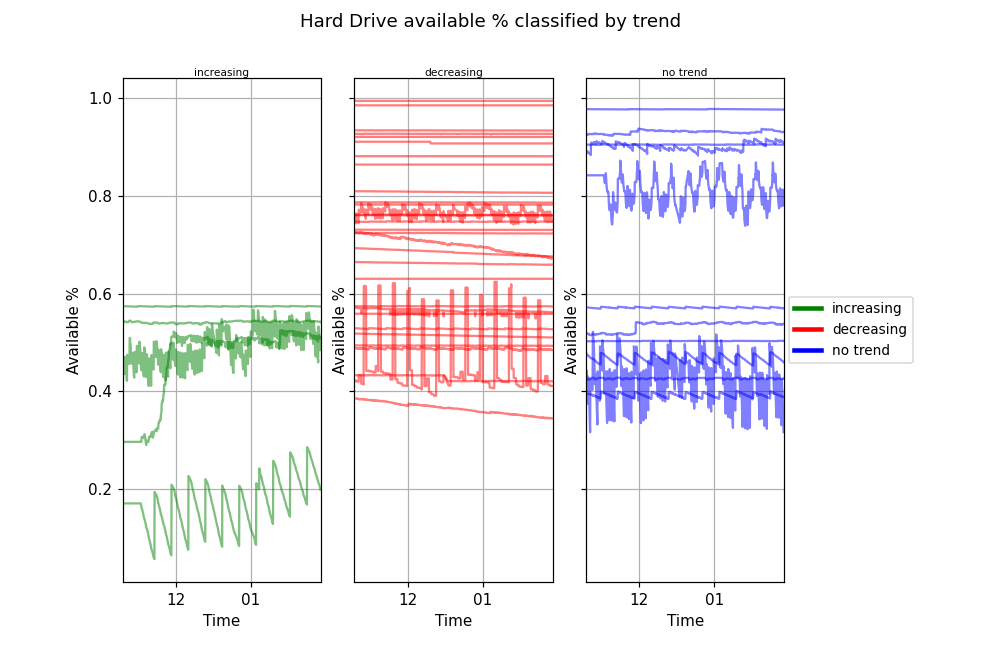

Text(0.5, 0.98, 'Hard Drive available % classified by trend')

In [39]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = trend_df[:]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 4, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 3, 3, 1]})



dic_color = {'increasing':'green', 'decreasing':'red', 'no trend':'blue'}
inc_ax, dec_ax, not_ax, lax = axs

for col in df_plot.columns:
    if dic_features[col]['trend']['test'] == 'increasing':
        inc_ax.plot(df_plot.index, df_plot[col], label=col,color=dic_color[dic_features[col]['trend']['test']], linewidth=1.5, alpha=0.5)
        
    elif dic_features[col]['trend']['test'] == 'decreasing':
        dec_ax.plot(df_plot.index, df_plot[col], label=col,
                    color=dic_color[dic_features[col]['trend']['test']], 
                     linewidth=1.5, alpha=0.5)
    
    
    else:
        not_ax.plot(df_plot.index, df_plot[col], label=col,
                    color=dic_color[dic_features[col]['trend']['test']], 
                    linewidth=1.5, alpha=0.5)
    
    
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')



labels = ['increasing', 'decreasing', 'no trend']

for i, pax in enumerate(axs[:-1]):
    
    pax.set_ylabel("Available %")
    pax.set_xlabel("Time")
    pax.set_title(labels[i], fontsize=7, pad=0.5)

    # format the ticks
    pax.xaxis.set_major_locator(months)
    pax.xaxis.set_major_formatter(month_fmt)
    # pax.xaxis.set_minor_locator(months)
    pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    pax.grid(True)

    datemin = np.datetime64(df_plot.index[0], 'D')
    datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
    pax.set_xlim(datemin, datemax)

    
    
    
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Hard Drive available % classified by trend")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

La figure ci-dessus dissocie dans différente fenêtre chaque type de signal caractérisé par sa tendance. Cette figure nous permet de mieux visualiser les courbes qui dans la figure précédente étaient regroupées dans une même fenêtre graphique. 

### Test de saisonalité

Un autre indicateur qui s'avère très utile quand on analyse des données chronologique est la saisonnalité des données et leur période. 
Si cette composante de saisonnalité est détectée, nous pouvons non seulement l'éliminer pour mieux identifier les autres caractéristiques du signal mais aussi l'associer au signal comme étant un attribut pour réaliser des classifications plus pérformantes.
A l’heure actuelle notre recherche a montré que pour des données chronologiques de grande taille les bibliographies sur ce sujet sont assez récentes et par conséquent il faut faire une recherche approfondie pour trouver le test qui est le mieux adapté pour les données.   
Dans cette partie nous avons fait quelques expériences dans le but de détecter la saisonnalités de nos signaux en utilisant la transformée de Fourier et en analysant la stationnarité des signaux en enlevant la composante Trend obtenue à l'aide de la fonction seasonal_decompose. 

In [94]:
# Remove Nans to apply statistics tests

sea_df = df_hourly.interpolate()
sea_df.fillna(method='bfill', inplace=True)

# Creating dictionary for each statistic test
for col in sea_df.columns:
    trend = seasonal_decompose(sea_df[col]).trend
    trend.interpolate(inplace=True)
    trend.fillna(method='bfill', inplace=True)
    sea_series = sea_df[col] - trend
    test = adfuller(sea_series)
    #test = pmk.hamed_rao_modification_test(pmk_series, alpha=0.05) # Test that deals with autocorrelation
    print(col, ':', test[1])
    dic_features[col]['seasonality'] = {}
    #dic_features[col]['seasonality']['test'] = 
    dic_features[col]['seasonality']['p_value'] = test[1]
    
    #no_trend_df[col] = no_trend_df[col] - seasonal_decompose(no_trend_df[col]).trend
    

disk1 : 5.830665972735034e-21
disk2 : 4.6088243089137596e-23
disk3 : 1.3262616946144255e-25
disk4 : 4.424771030504629e-20
disk5 : 3.713429258186869e-23
disk6 : 2.193165347464632e-26
disk7 : 7.646558502428532e-22
disk8 : 1.14932435682983e-22
disk9 : 3.7114061390714985e-19
disk10 : 7.915117529575566e-27
disk11 : 8.102367098488671e-25
disk12 : 7.914411578485229e-26
disk13 : 2.3296329113993262e-18
disk14 : 7.172064229378429e-21
disk15 : 1.1183924033485837e-26
disk16 : 4.503618424544744e-27
disk17 : 5.979471606311057e-22
disk18 : 1.7948392706773413e-24
disk19 : 2.0589078043929077e-09
disk20 : 5.192731292055851e-24
disk21 : 1.6227034111273677e-25
disk22 : 7.230606690195206e-27
disk23 : 2.2468031019916343e-20
disk24 : 5.944720869500596e-26
disk25 : 2.0324977006279383e-22
disk26 : 5.865863820480022e-22
disk28 : 9.715986857524803e-27
disk29 : 8.38524593025301e-26
disk30 : 1.980451242669446e-26
disk31 : 1.1269169438451824e-22
disk32 : 1.4973676339269664e-22
disk33 : 6.716091403812176e-23
disk34 

In [ ]:
# fft

In [82]:
X = fft(trend_df['disk12'].values) #compute X[k]

<IPython.core.display.Javascript object>


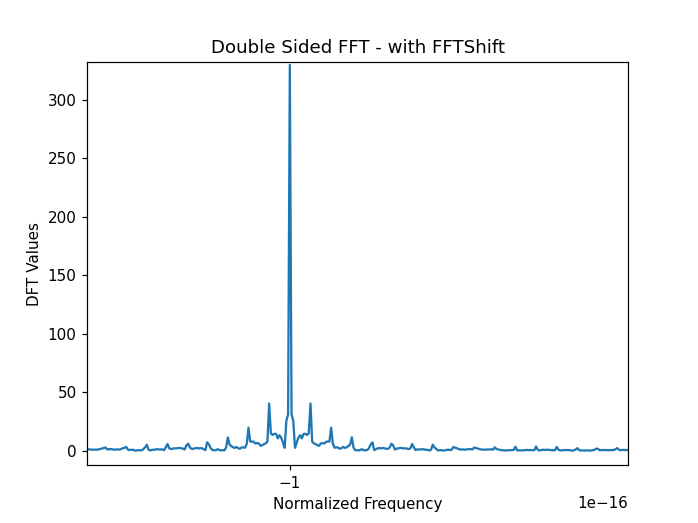

In [42]:
NFFT=2000 #NFFT-point DFT      
X=fftshift(fft(trend_df['disk12'].values,NFFT)) #compute DFT using FFT  

fig3, ax = plt.subplots(nrows=1, ncols=1) #create figure handle
    
fVals=np.arange(start = -NFFT/2,stop = NFFT/2)/NFFT #DFT Sample points        
ax.plot(fVals,np.abs(X))
ax.set_title('Double Sided FFT - with FFTShift')
ax.set_xlabel('Normalized Frequency')
ax.set_ylabel('DFT Values');
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xticks(np.arange(-0.5, 0.5+0.1,0.1))
fig.show()

In [108]:
# signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)

fourier = np.fft.fft(trend_df['disk36'].values)

n = len(trend_df['disk36'].values)

timestep = 0.1

freq = np.fft.fftfreq(n, d=timestep)

freq

array([ 0.        ,  0.00512033,  0.01024066, ..., -0.01536098,
       -0.01024066, -0.00512033])

<IPython.core.display.Javascript object>


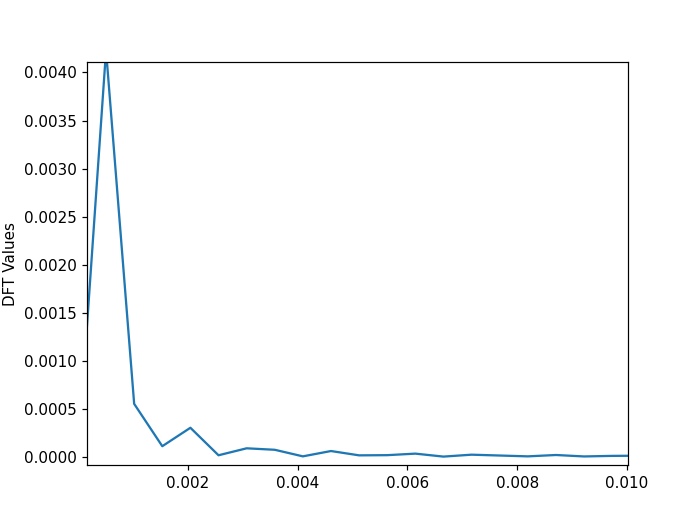

In [174]:
disk = 'disk8'
series = trend_df[disk].copy()

f, p = periodogram(series)


fig3, ax = plt.subplots(nrows=1, ncols=1) #create figure handle
    
ax.plot(f,np.abs(p))
#ax.set_title('Double Sided FFT - with FFTShift')
#ax.set_xlabel('Normalized Frequency')
ax.set_ylabel('DFT Values');
ax.autoscale(enable=True, axis='x', tight=True)
#ax.set_xticks(np.arange(-0.5, 0.5+0.1,0.1))
fig.show()

A la suite de nos différents essais avec l'objectif de détecter la saisonnalité des signaux, nous pouvons conlure qu'une recherche approfondie et plus détaillée est nécessaire pour conduire les travaux proprement sur ce sujet. 
Cette conclusion est principalement résultat de nos observations de p-values quand on a fait le test de stationnairté. En effet cet indicateur n'a pas été correctement calculé pour plusieurs signaux. Le test nous donnant une information que le signal comporte une saisonnalité, alors que visuellement nous nous apercevons que cela n'est pas le cas ou inversement. 
Quant à la transformée de Fourier, nous n'avons pas pu trouvé une valeur d'amplitude limite signalant qu'une fréquence est bien plus présente dans le signal qu'une autre. 

#### Calcul d'indicateurs (au pas de temps de quotidien)


La vitesse de remplissage de disque est une métrique qui nous permet d'évaluer la rapidité de consommation de l'espace de stockage. Un outil efficace pour déterminer cet indicateur est la dérivée. 
Ici, nous proposons aux futurs contributeurs du projet d'analyser les indicateurs statistiques de la vitesse de remplissage journalière comme:
- Moyenne 
- Variance
- Médiane
- Quartile 25%
- Quartile 75%
- Min
- Max
- p-value test de saisonalité (si concluant)
- p-value test de tendance

Il peut être utile de récupérer ces features dans un tableau et d'ajouter ces indicateurs pour qu'ils soient tous dans le même dictionnaire. L'étude peut être réalisée au pas de temps horaire ou quotidien. Voici à quoi ressemblerait la construction d'une telle structure avec tous les indicateurs.

In [123]:
# Generating array of features for all 50 disks

n_features = 9
features = [[0 for j in range(n_features)] 
            for i in range(nb_total_disk)]

In [124]:
features_tab

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [125]:

# We can either use the initial dataframe or the dataframe of derivatives
for i, col in enumerate(df_daily.columns):
    features[i][0] = df_hourly[col].mean()
    features[i][1] = df_hourly[col].var()
    features[i][2] = df_hourly[col].median()
    features[i][3] = df_hourly[col].quantile(q=0.25)
    features[i][4] = df_hourly[col].quantile(q=0.75)
    features[i][5] = df_hourly[col].min()
    features[i][6] = df_hourly[col].max()
    
    
    

## Classification

### KMeans

La classification de données est une partie incontournable lors d'un projet d'analyse de données. Une méthode souvent employée est la methode K-means qui est un partionnemement de données en resolvant un problème d'optimisation. Le problème est de répartir des points (dans notre cas des points en 1953 dimensions) dans k clusters de façon à minimiser la fonction qui est la somme des carrées des distances entre nos points et la moyenne des points de chaque cluster. 
Pour évaluer cette dsitance nous pouvons utiliser différentes méthode de mesure de distance comme: 
- la distance Euclidienne 
- la DTW (Déformation Temporelle Dynamique) <br>

Dans notre scnéario d'étude nous lançons cet algorithme avec la DTW. 

#### DTW

Dans un premier temps pour nous approprier cette notion de Déformation Temporelle Dynamique et pour comparer les résultats de classification faites avec une distance Euclideinne et la DTW, nous executons un exemple qui met en évidence ces deux classifications.
La mesure de DTW est très efficace quand on veut mesurer les similarités entre deux suites pouvant varier au cours du temps. Un cas d'application très connu est la reconnaissance automatique de parole. 

Pour illustrer notre exemple nous allons générer 50 random walks et allons analyser leur classification par un K-means euclidien et DTW.

In [132]:
X = random_walks(n_ts=50, sz=32, d=1)
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5,
                      random_state=0).fit(X)
km.cluster_centers_

array([[[-0.28356334],
        [-0.5722346 ],
        [-0.56502265],
        [-0.78300743],
        [-0.89483915],
        [-0.78919179],
        [-0.68192781],
        [-0.78488879],
        [-0.7936407 ],
        [-0.86944832],
        [-1.32890601],
        [-1.46151367],
        [-1.70627451],
        [-1.58887188],
        [-1.9624586 ],
        [-2.93299976],
        [-2.95101278],
        [-3.09748739],
        [-4.00119636],
        [-4.19321641],
        [-4.1153871 ],
        [-4.49739545],
        [-4.81148853],
        [-4.95401927],
        [-5.35599565],
        [-5.22301211],
        [-5.39394058],
        [-5.3680541 ],
        [-5.1529576 ],
        [-5.09307712],
        [-5.40717323],
        [-5.61366023]],

       [[-0.09392053],
        [ 0.23648463],
        [ 0.63219833],
        [ 0.60639111],
        [ 1.03424647],
        [ 1.38155508],
        [ 1.6367217 ],
        [ 1.71745039],
        [ 1.71081477],
        [ 1.73990854],
        [ 1.91531122],
        [

In [133]:
X = random_walks(n_ts=50, sz=32, d=1)
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5,
                      random_state=0).fit_predict(X)

In [134]:
km

array([2, 2, 1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 1, 1,
       2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2,
       0, 1, 0, 2, 1, 1], dtype=int64)

<IPython.core.display.Javascript object>


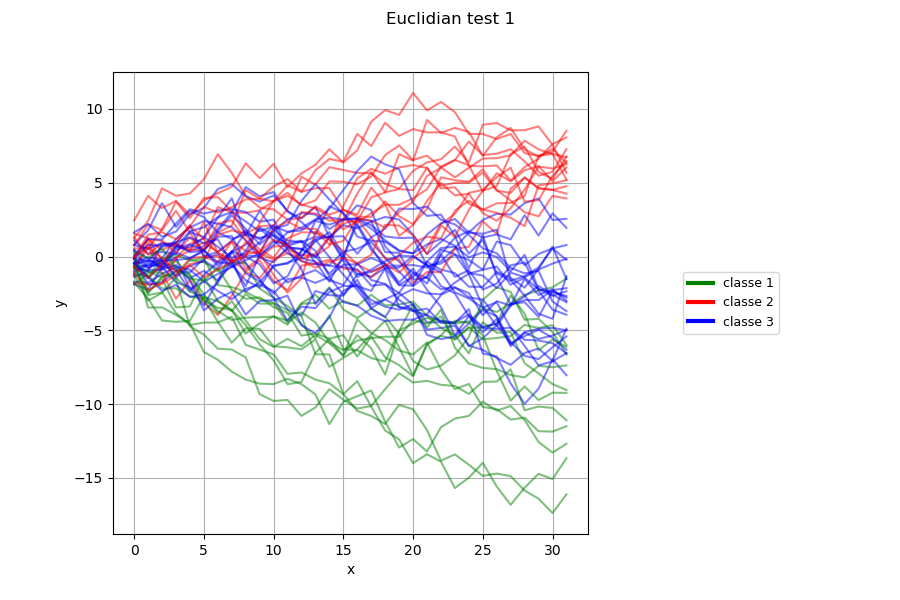

Text(0.5, 0.98, 'Euclidian test 1')

In [135]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


x_axis = [i for i in range(0,32)]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})

dic_color = {0:'green', 1:'red', 2:'blue'}
pax, lax = axs

for i, individu in enumerate(X[:]):
    tab_val = [ val[0] for val in individu ]
    
    pax.plot(x_axis, tab_val, color=dic_color[km[i]], linewidth=1.5, alpha=0.5)
        
    
    
#pax.grid(True)

#years = mdates.YearLocator() 
#months = mdates.MonthLocator()
#day = mdates.HourLocator()
#month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')


    
pax.grid(True)

labels = ['classe 1', 'classe 2', 'classe 3']
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)
pax.set_ylabel("y")
pax.set_xlabel("x")

# ----------------

fig.suptitle("Euclidian test 1")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

<IPython.core.display.Javascript object>


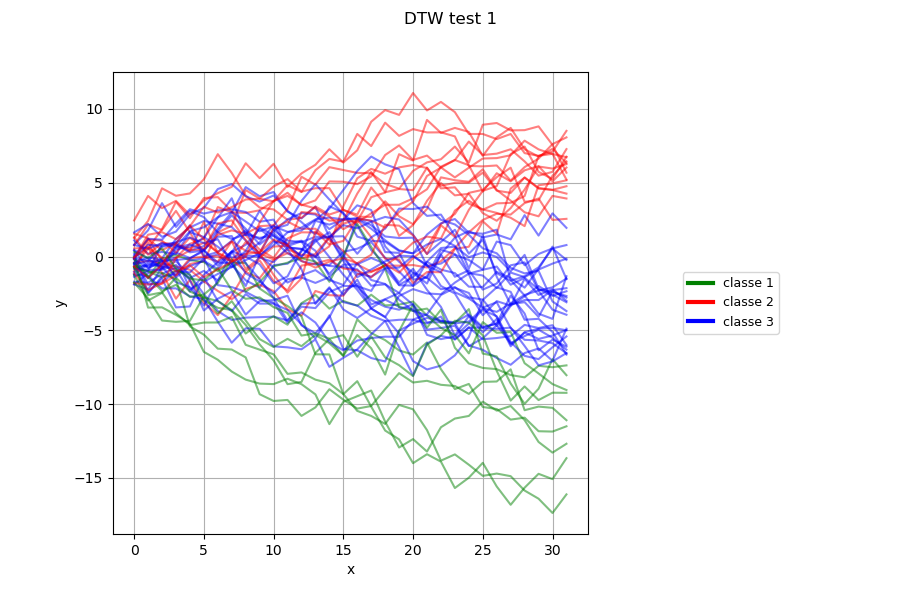

Text(0.5, 0.98, 'DTW test 1')

In [136]:
#X = random_walks(n_ts=50, sz=32, d=1)
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5,
                      random_state=0).fit_predict(X)


start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


x_axis = [i for i in range(0,32)]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})

dic_color = {0:'green', 1:'red', 2:'blue'}
pax, lax = axs

for i, individu in enumerate(X[:]):
    tab_val = [ val[0] for val in individu ]
    
    pax.plot(x_axis, tab_val, color=dic_color[km[i]], linewidth=1.5, alpha=0.5)
        
    
    
#pax.grid(True)

#years = mdates.YearLocator() 
#months = mdates.MonthLocator()
#day = mdates.HourLocator()
#month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')


    
pax.grid(True)

labels = ['classe 1', 'classe 2', 'classe 3']
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)
pax.set_ylabel("y")
pax.set_xlabel("x")

# ----------------

fig.suptitle("DTW test 1")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

##### Normalisation des données 

Les méthodes de normalisation des données sont utilisées pour que les variables, mesurées à différentes échelles, aient des valeurs comparables. Cette étape de prétraitement est importante pour le regroupement et la visualisation de différents type de graphes et notamment des graphes résultant des algorithmes d’apprentissage machine basés sur des mesures de distance. 
Les normalisations les plus fréquentes dans le domaine d'analyse de données sont : 
- La normalisation Standard (La Standardisation ou z-score) 
- La normalisation permettant de placer nos données entre 0 et 1 

##### Centrée Réduite 4 clusters

Pendant cette étape nous appliquons la normalisation Standard à notre jeu de données et nous nous intéressons à la classification de 4 clusters en optant pour la méthode de mesure de la distance DTW. 

In [ ]:
norm_df = pd.DataFrame(index=trend_df.index)

for col in trend_df.columns:
    norm_df[col] = (trend_df[col]-trend_df[col].mean())/trend_df[col].std()
    
    
norm_df.head()

In [284]:
# This takes 25 minutes to run that is why the result is normally pickled.
X = [[[e] for e in norm_df[col]] for col in norm_df.columns]

km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10,
                      random_state=0).fit_predict(X)

<IPython.core.display.Javascript object>


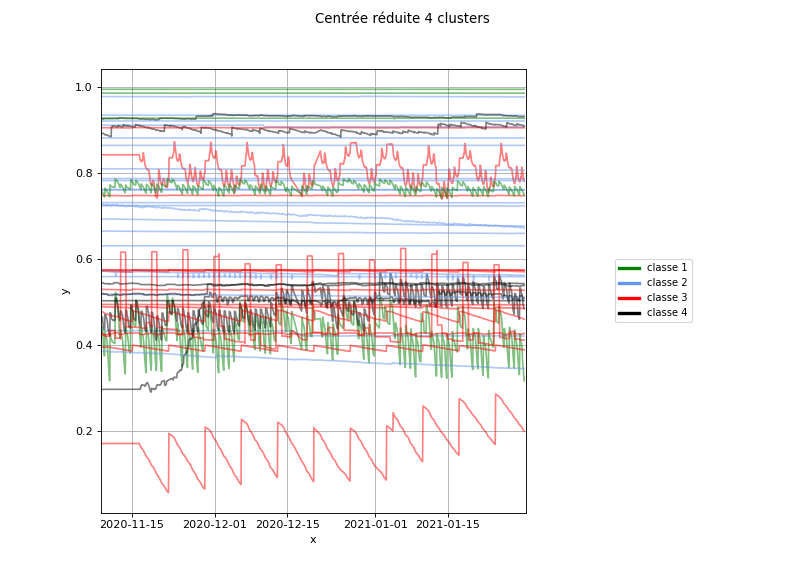

Text(0.5, 0.98, 'Centrée réduite 4 clusters')

In [324]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"



# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})

dic_color = {0:'green', 1:'cornflowerblue', 2:'red', 3:'black'}
pax, lax = axs

for i, col in enumerate(trend_df.columns):
    
    #print(dic_color[km[i]])
    
    pax.plot(trend_df.index, trend_df[col], color=dic_color[km[i]], 
             linewidth=1.5, alpha=0.5)
        
    
    
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
month_fmt = mdates.ConciseDateFormatter('%m')


datemin = np.datetime64(df_plot.index[0], 'D')
datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
pax.set_xlim(datemin, datemax)
#pax.set_ylim(0, 1)

    
pax.grid(True)

labels = ['classe 1', 'classe 2', 'classe 3', 'classe 4']
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)
pax.set_ylabel("y")
pax.set_xlabel("x")

# ----------------

fig.suptitle("Centrée réduite 4 clusters")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

Le graphe ci-dessus nous montre la classification de nos signaux, mais il est évident que son observation et son analyse sont difficiles. Faisons maintenant une figure où chaque cluster est localisé dans une figure sans être mélangé avec les signaux des autres clusters. 

<IPython.core.display.Javascript object>


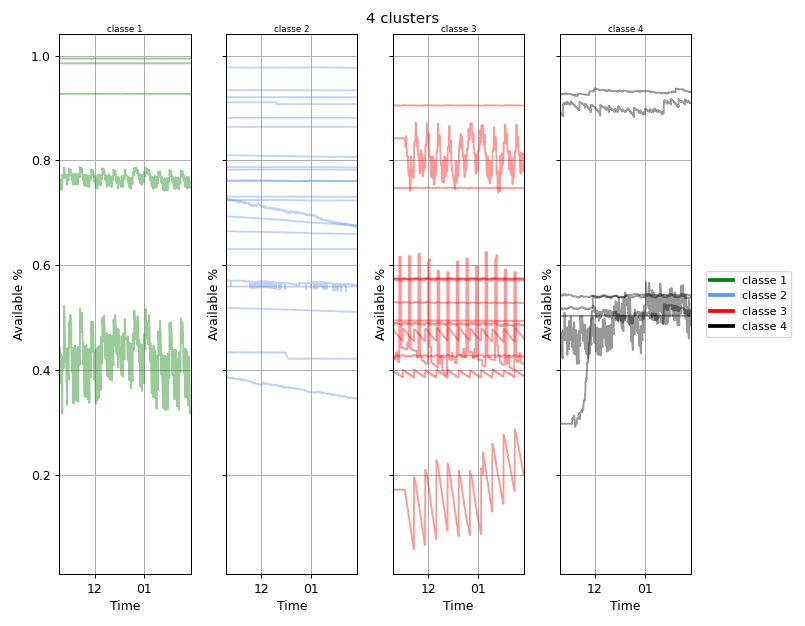

In [146]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = trend_df

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 5, sharex=True, 
                        sharey=True,
                        figsize=(9, 7),
                        gridspec_kw={"width_ratios": [3, 3, 3, 3, 1]})


dic_color = {0:'green', 1:'cornflowerblue', 2:'red', 3:'black'}

pax1, pax2, pax3, pax4, lax = axs

for i, col in enumerate(df_plot.columns):
    
    #print(col)
    #print(km[i])
    
    if km[i] == 0:
        pax1.plot(df_plot.index, df_plot[col], label=col,color=dic_color[km[i]], 
                  linewidth=1.5, alpha=0.4)
                
    elif km[i] == 1:
        pax2.plot(df_plot.index, df_plot[col], label=col,color=dic_color[km[i]], 
                  linewidth=1.5, alpha=0.4)

    elif km[i] == 2:
        pax3.plot(df_plot.index, df_plot[col], label=col,color=dic_color[km[i]],
                  linewidth=1.5, alpha=0.4)

    else:
        pax4.plot(df_plot.index, df_plot[col], label=col,color=dic_color[km[i]],
                  linewidth=1.5, alpha=0.4)

    
    
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')



labels = ['classe 1', 'classe 2', 'classe 3', 'classe 4']

for i, pax in enumerate(axs[:-1]):
    
    pax.set_ylabel("Available %")
    pax.set_xlabel("Time")
    pax.set_title(labels[i], fontsize=7, pad=0.5)

    # format the ticks
    pax.xaxis.set_major_locator(months)
    pax.xaxis.set_major_formatter(month_fmt)
    # pax.xaxis.set_minor_locator(months)
    pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    pax.grid(True)

    datemin = np.datetime64(df_plot.index[0], 'D')
    datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
    pax.set_xlim(datemin, datemax)

    
    
    
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("4 clusters")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])

Ce qu'on peut déduire de cette figure est que :
- le cluster 2 continent des signaux qui sont à variance constante 
- le cluster 3 contient des signaux plutôt périodiques 
- le cluster 1 a pu regrouper les signaux bruités 
- le cluster 4 a recolté des signaux qui ont plutôt une allure aléatoire

Sur le graphe, ne pouvant pas avoir directement l'accés de l'ID de chaque disque, nous avons écrit un petit bout de code nous permettant de repérer les disques dans chaque cluster. Nous décidons de stocker ces résultats dans un dictionnaire.

In [373]:
dic_results = {}
dic_results["norm_std_4"] = {}


for clus in range(0,4):
    print("cluster " ,clus+1)
    dic_results["norm_std_4"][clus+1] = []
    for i, col in enumerate(df_plot.columns):
        if clus == km[i]:
            dic_results["norm_std_4"][clus+1].append(col)


dic_results['norm_std_4']

{1: ['disk9', 'disk10', 'disk46', 'disk48', 'disk49'],
 2: ['disk1',
  'disk3',
  'disk4',
  'disk5',
  'disk7',
  'disk8',
  'disk11',
  'disk15',
  'disk17',
  'disk19',
  'disk20',
  'disk21',
  'disk26',
  'disk31',
  'disk32',
  'disk33',
  'disk34',
  'disk36',
  'disk40',
  'disk41',
  'disk43',
  'disk47'],
 3: ['disk2',
  'disk6',
  'disk12',
  'disk13',
  'disk23',
  'disk25',
  'disk28',
  'disk29',
  'disk30',
  'disk37',
  'disk38',
  'disk39',
  'disk44',
  'disk45'],
 4: ['disk14', 'disk16', 'disk18', 'disk22', 'disk24', 'disk35', 'disk42']}

Pour éviter d'avoir à recalculer nous sauvegardons la répartition dans un fichier .pkl

In [296]:
SAVE_DATA = False # Dumping classification in .pkl file

if SAVE_DATA:
    print("Saving data")
    with open(PROC_KM_STD_NORM, 'wb') as f:
        pickle.dump(km, f)

In [28]:
#with open(PROC_KM_STD_NORM, 'rb') as f:
#    mynewlist = pickle.load(f)

##### Centrée réduite 3 clusters

La conclusion que nous avons tirée de la classification que nous venons d'effectuer nous a fait réflechir sur le nombre de clusters. Il semblerait que le cluster 3 et le cluster 4 soient assez similaires. Nous voudrions maitenant obtenir le résultat en lançant l'algorithme de K-means avec un attibut n_clusters = 3.  

In [297]:
# Takes almost 23 minutes to run
X = [[[e] for e in norm_df[col]] for col in norm_df.columns]

km_3_norm_std = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10,
                      random_state=0).fit_predict(X)

In [319]:
SAVE_DATA = False

if SAVE_DATA:
    print("Saving data")
    with open(PROC_KM_STD_NORM_3CLS, 'wb') as f:
        pickle.dump(km_3_norm_std, f)

Saving data


In [302]:
#with open(PROC_KM_STD_NORM_3CLS, 'rb') as f:
    #mynewlist = pickle.load(f)

<IPython.core.display.Javascript object>


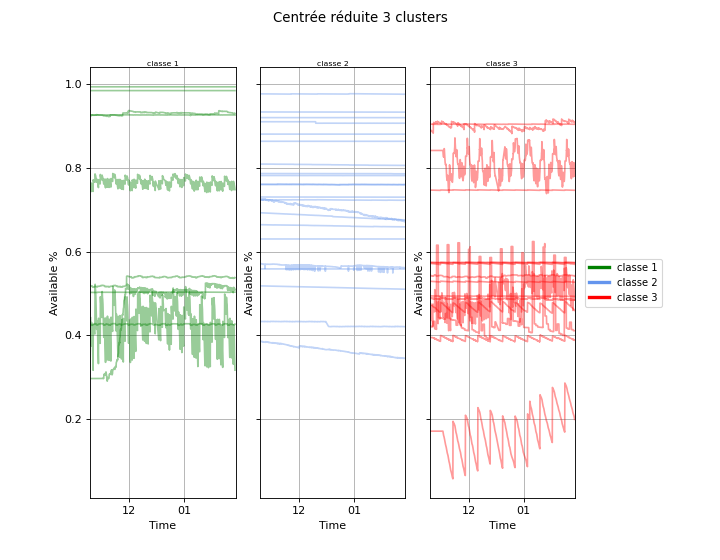

1
2
1
1
1
2
1
1
0
0
1
2
2
2
1
0
1
0
1
1
1
0
0
2
2
1
2
2
2
1
1
1
1
0
1
2
2
2
1
1
2
1
2
2
0
1
0
0


Text(0.5, 0.98, 'Centrée réduite 3 clusters')

In [354]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = trend_df

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 4, sharex=True, 
                        sharey=True,
                        figsize=(9, 7),
                        gridspec_kw={"width_ratios": [3, 3, 3, 1]})


dic_color = {0:'green', 1:'cornflowerblue', 2:'red', 3:'black'}

pax1, pax2, pax3, lax = axs

for i, col in enumerate(df_plot.columns):
    #print(i)
    #print(col)
    print(km_3_norm_std[i])
    
    if km_3_norm_std[i] == 0:
        pax1.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_3_norm_std[i]], linewidth=1.5, alpha=0.4)
                
    elif km_3_norm_std[i] == 1:
        pax2.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_3_norm_std[i]], linewidth=1.5, alpha=0.4)

    elif km_3_norm_std[i] == 2:
        pax3.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_3_norm_std[i]], linewidth=1.5, alpha=0.4)

 #   else:
  #      pax4.plot(df_plot.index, df_plot[col], label=col,
  #                color=dic_color[km_3_norm_std[i]], linewidth=1.5, alpha=0.4)

    
    
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')



labels = ['classe 1', 'classe 2', 'classe 3']

for i, pax in enumerate(axs[:-1]):
    
    pax.set_ylabel("Available %")
    pax.set_xlabel("Time")
    pax.set_title(labels[i], fontsize=7, pad=0.5)

    # format the ticks
    pax.xaxis.set_major_locator(months)
    pax.xaxis.set_major_formatter(month_fmt)
    # pax.xaxis.set_minor_locator(months)
    pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    pax.grid(True)

    datemin = np.datetime64(df_plot.index[0], 'D')
    datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
    pax.set_xlim(datemin, datemax)

    
    
    
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Centrée réduite 3 clusters")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

En regardant le graphe ci-dessus, visuellement nous pouvons dire que nos attentes ont été atteintes. Pour vérfier est-ce que réellement les signaux du cluster 3 et du clsuter 4 issus de la classification avec n_clusters = 4, se sont regroupés pour créer un cluster lors de la classification avec n_clusters = 3, nous avons écrit un code nous permettant d'identifier quels signaux ont changé leur cluster. 

In [843]:
# Iterating over all columns (disks)
# Finding where it was classified with 3 centeroids in dic norm_std_3
# Finding where it was classified with 4 centeroids in dic norm_std_4
# it the two are different we plot display the orgin and destination


for i, col in enumerate(trend_df.columns):
    origin = None
    destination = None
    
    for j in range(0,4):
        if col in dic_results['norm_std_3'][j+1]:
            origin = j+1
            
            
        if col in dic_results['norm_std_4'][j+1]:
            destination = j+1
    
    
        if origin != None and destination != None and origin != destination:
            print('{} went from cluster {} to cluster {}'.format(col,origin,destination))
            break

disk14 went from cluster 3 to cluster 4
disk16 went from cluster 1 to cluster 4
disk18 went from cluster 1 to cluster 4
disk22 went from cluster 1 to cluster 4
disk23 went from cluster 1 to cluster 3
disk24 went from cluster 3 to cluster 4
disk35 went from cluster 1 to cluster 4
disk42 went from cluster 3 to cluster 4


On remarque que la majorité sont passés du cluster 3 ou 1 au cluster 4.

In [374]:
# Adding results to dictionary
dic_results["norm_std_3"] = {}


for clus in range(0,4):
    print("cluster " ,clus+1)
    dic_results["norm_std_3"][clus+1] = []
    for i, col in enumerate(df_plot.columns):
        if clus == km_3_norm_std[i]:
            dic_results["norm_std_3"][clus+1].append(col)

cluster  1
cluster  2
cluster  3
cluster  4


In [375]:
dic_results["norm_std_3"]

{1: ['disk9',
  'disk10',
  'disk16',
  'disk18',
  'disk22',
  'disk23',
  'disk35',
  'disk46',
  'disk48',
  'disk49'],
 2: ['disk1',
  'disk3',
  'disk4',
  'disk5',
  'disk7',
  'disk8',
  'disk11',
  'disk15',
  'disk17',
  'disk19',
  'disk20',
  'disk21',
  'disk26',
  'disk31',
  'disk32',
  'disk33',
  'disk34',
  'disk36',
  'disk40',
  'disk41',
  'disk43',
  'disk47'],
 3: ['disk2',
  'disk6',
  'disk12',
  'disk13',
  'disk14',
  'disk24',
  'disk25',
  'disk28',
  'disk29',
  'disk30',
  'disk37',
  'disk38',
  'disk39',
  'disk42',
  'disk44',
  'disk45'],
 4: []}

###### Normalisé min max 4 clusters

Voici une autre manière de classifier les données en utilisant l'autre moyen de normalisation qui nous permet de replacer les données entre 0 et 1. 


In [305]:
normalized_df = (trend_df-trend_df.min())/(trend_df.max()-trend_df.min())

In [316]:
# Takes almost 20 minutes to run
X = [[[e] for e in normalized_df[col]] for col in normalized_df.columns]

km_normalized_4cls = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10,
                      random_state=0).fit_predict(X)

In [320]:
SAVE_DATA = False

if SAVE_DATA:
    print("Saving data")
    with open(PROC_KM_NORM_4CLS, 'wb') as f:
        pickle.dump(km_normalized_4cls, f)

Saving data


<IPython.core.display.Javascript object>


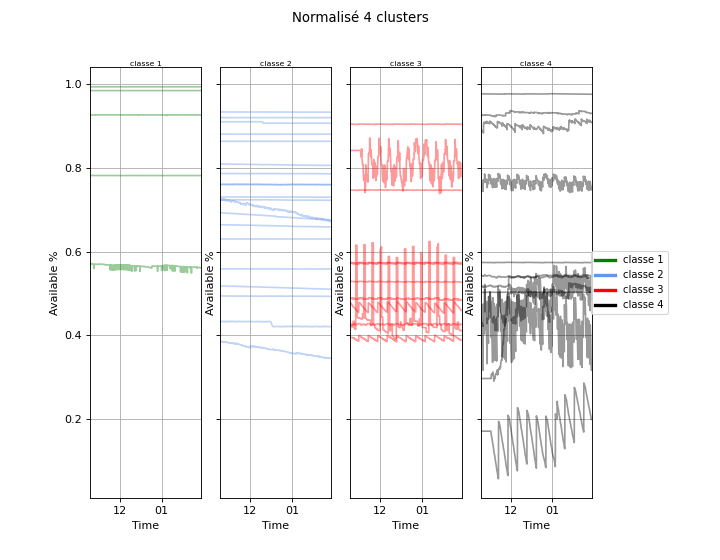

Text(0.5, 0.98, 'Normalisé 4 clusters')

In [355]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = trend_df

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 5, sharex=True, 
                        sharey=True,
                        figsize=(9, 7),
                        gridspec_kw={"width_ratios": [3, 3, 3, 3, 1]})


dic_color = {0:'green', 1:'cornflowerblue', 2:'red', 3:'black'}

pax1, pax2, pax3, pax4, lax = axs

for i, col in enumerate(df_plot.columns):
    
    #print(col)
    #print(km[i])
    
    if km_normalized_4cls[i] == 0:
        pax1.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_4cls[i]], 
                  linewidth=1.5, alpha=0.4)
                
    elif km_normalized_4cls[i] == 1:
        pax2.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_4cls[i]], 
                  linewidth=1.5, alpha=0.4)

    elif km_normalized_4cls[i] == 2:
        pax3.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_4cls[i]], 
                  linewidth=1.5, alpha=0.4)

    else:
        pax4.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_4cls[i]], 
                  linewidth=1.5, alpha=0.4)

        
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')



labels = ['classe 1', 'classe 2', 'classe 3', 'classe 4']

for i, pax in enumerate(axs[:-1]):
    
    pax.set_ylabel("Available %")
    pax.set_xlabel("Time")
    pax.set_title(labels[i], fontsize=7, pad=0.5)

    # format the ticks
    pax.xaxis.set_major_locator(months)
    pax.xaxis.set_major_formatter(month_fmt)
    # pax.xaxis.set_minor_locator(months)
    pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    pax.grid(True)

    datemin = np.datetime64(df_plot.index[0], 'D')
    datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
    pax.set_xlim(datemin, datemax)

    
    
    
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Normalisé 4 clusters")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

In [377]:
dic_results["normalized_4"] = {}

for clus in range(0,4):
    print("cluster " ,clus+1)
    dic_results["normalized_4"][clus+1] = []
    for i, col in enumerate(df_plot.columns):
        if clus == km_normalized_4cls[i]:
            dic_results["normalized_4"][clus+1].append(col)

cluster  1
cluster  2
cluster  3
cluster  4


In [378]:
dic_results["normalized_4"]

{1: ['disk10', 'disk15', 'disk43', 'disk46', 'disk49'],
 2: ['disk1',
  'disk3',
  'disk4',
  'disk5',
  'disk7',
  'disk8',
  'disk17',
  'disk19',
  'disk20',
  'disk21',
  'disk26',
  'disk31',
  'disk32',
  'disk33',
  'disk34',
  'disk36',
  'disk40',
  'disk41',
  'disk45',
  'disk47'],
 3: ['disk6',
  'disk13',
  'disk23',
  'disk25',
  'disk28',
  'disk29',
  'disk30',
  'disk37',
  'disk38',
  'disk39',
  'disk44'],
 4: ['disk2',
  'disk9',
  'disk11',
  'disk12',
  'disk14',
  'disk16',
  'disk18',
  'disk22',
  'disk24',
  'disk35',
  'disk42',
  'disk48']}

###### Normalisé min max 3 clusters

On utilise la même normalisation mais avec 3 clusters

In [317]:
X = [[[e] for e in normalized_df[col]] for col in normalized_df.columns]

km_normalized_3cls = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10,
                      random_state=0).fit_predict(X)

In [322]:
SAVE_DATA = False

if SAVE_DATA:
    print("Saving data")
    with open(PROC_KM_NORM_3CLS, 'wb') as f:
        pickle.dump(km_normalized_3cls, f)

<IPython.core.display.Javascript object>


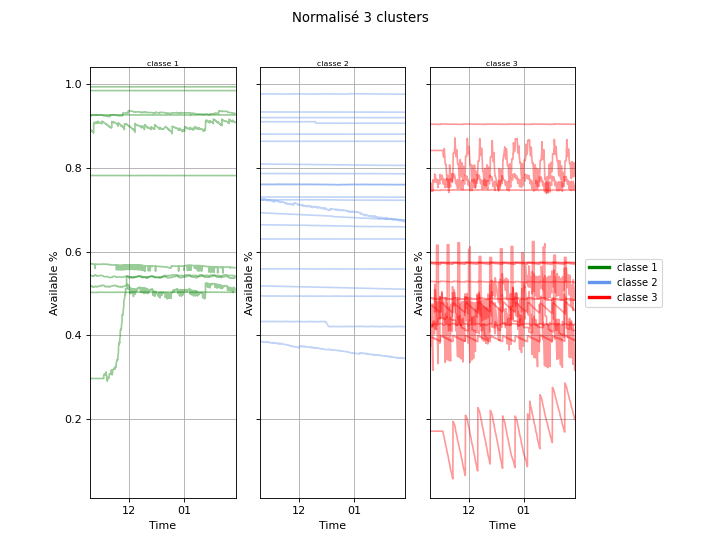

1
2
1
1
1
2
1
1
0
0
1
2
2
2
1
0
1
0
1
1
1
0
0
2
2
1
2
2
2
1
1
1
1
0
1
2
2
2
1
1
2
1
2
2
0
1
0
0


Text(0.5, 0.98, 'Normalisé 3 clusters')

In [359]:
start = "2020-11-09 08:00:00"
end = "2021-01-29 16:00:00"


df_plot = trend_df

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 4, sharex=True, 
                        sharey=True,
                        figsize=(9, 7),
                        gridspec_kw={"width_ratios": [3, 3, 3, 1]})


dic_color = {0:'green', 1:'cornflowerblue', 2:'red', 3:'black'}

pax1, pax2, pax3, lax = axs

for i, col in enumerate(df_plot.columns):
    #print(i)
    #print(col)
    print(km_3_norm_std[i])
    
    if km_normalized_3cls[i] == 0:
        pax1.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_3cls[i]], linewidth=1.5, alpha=0.4)
                
    elif km_normalized_3cls[i] == 1:
        pax2.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_3cls[i]], linewidth=1.5, alpha=0.4)

    elif km_normalized_3cls[i] == 2:
        pax3.plot(df_plot.index, df_plot[col], label=col,
                  color=dic_color[km_normalized_3cls[i]], linewidth=1.5, alpha=0.4)

 #   else:
  #      pax4.plot(df_plot.index, df_plot[col], label=col,
  #                color=dic_color[km_3_norm_std[i]], linewidth=1.5, alpha=0.4)

    
    
#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
month_fmt = mdates.DateFormatter('%m')
#month_fmt = mdates.ConciseDateFormatter('%m')



labels = ['classe 1', 'classe 2', 'classe 3']

for i, pax in enumerate(axs[:-1]):
    
    pax.set_ylabel("Available %")
    pax.set_xlabel("Time")
    pax.set_title(labels[i], fontsize=7, pad=0.5)

    # format the ticks
    pax.xaxis.set_major_locator(months)
    pax.xaxis.set_major_formatter(month_fmt)
    # pax.xaxis.set_minor_locator(months)
    pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    pax.grid(True)

    datemin = np.datetime64(df_plot.index[0], 'D')
    datemax = np.datetime64(df_plot.index[-1], 'D') + np.timedelta64(1, 'D')
    pax.set_xlim(datemin, datemax)

    
    
    
    
lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_color.values()]
lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Normalisé 3 clusters")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

In [379]:
dic_results["normalized_3"] = {}

for clus in range(0,4):
    print("cluster " ,clus+1)
    dic_results["normalized_3"][clus+1] = []
    for i, col in enumerate(df_plot.columns):
        if clus == km_normalized_3cls[i]:
            dic_results["normalized_3"][clus+1].append(col)

cluster  1
cluster  2
cluster  3
cluster  4


In [382]:
dic_results['normalized_3']

{1: ['disk10',
  'disk15',
  'disk16',
  'disk18',
  'disk22',
  'disk24',
  'disk35',
  'disk42',
  'disk43',
  'disk46',
  'disk49'],
 2: ['disk1',
  'disk3',
  'disk4',
  'disk5',
  'disk7',
  'disk8',
  'disk11',
  'disk17',
  'disk19',
  'disk20',
  'disk21',
  'disk26',
  'disk31',
  'disk32',
  'disk33',
  'disk34',
  'disk36',
  'disk40',
  'disk41',
  'disk45',
  'disk47'],
 3: ['disk2',
  'disk6',
  'disk9',
  'disk12',
  'disk13',
  'disk14',
  'disk23',
  'disk25',
  'disk28',
  'disk29',
  'disk30',
  'disk37',
  'disk38',
  'disk39',
  'disk44',
  'disk48'],
 4: []}

On retiendra la méthode normalisée centrée réduite avec 4 clusters. En effet, on a vu qu'on obtenait un cluster saisonnalité, un cluster variation constante (négative ou nulle mais constante), et deux clusters plus bruités.
Lors du passage de 3 à 4 clusters nous avons remarqué une séparation de ces signaux qui étaient quasiment tous classifiés dans le cluster bruité (classe 1). 
Si le futur contributeur désire choisir une autre classification, les dictionnaires avec les résultats des partitions sont disponibles. Il suffit juste de reloader les fichier .pkl et exécuter les cellules avec dic_results.

Il est bien sûr possible de continuer à réaliser d'autres clustering pour les signaux et pour des raisons de temps, il a été décidé de passer à l'étape suivante en réalisant les premières prédictions. Cela dit le prochain contributeur du projet pourra continuer l'analyse en réalisant par exemple:
* Un clustering hierarchique
* Une DBSCAN
* Un clustering avec les indicateurs statistique des évolutions de disques durs
* Un clustering avec les indicateurs statistique des évolutions de dérivées

## Prédictions

Maintenant que nous avons identifié nos différents clusters, nous pouvons mettre au point les premiers modèles de prédicitions. Nous allons essayer différents modèles pour différents signaux. Le temps allouer au projet étant très court nous avons décidé de nous orienter en premier lieu vers les signaux ayant une allure monotone et une décroissance. En effet ces disques sont les plus simples à modéliser et ont le plus de chance de retrouver saturer, d'où la nécessité d'étudier leur futurs états.

Avant de commencer à faire notre modèle nous informons le lecteur que nous réalisons tout d'abord notre étude au pas de temps horaire avec une répartition entre jeu de d'entraînement et test respectivement de 66% et 33%. 

Le jeu d'entraînement comprendra donc 2 mois et celui de test un peu moins d'un mois (28 jours pour être exacte).

Les métriques que nous allons utiliser sont la RMSE, la MAE et la MAPE.

### Prédiction d'un signal issu du cluster variation monotone (classe 2)

Les signaux présents dans ce cluster sont les mêmes que l'on utilise 3 ou 4 clusters.

In [37]:
# Retrieving all disks that were classified as monotonous from the
# normalized std data with 4 clusters
list_monotone = dic_results['norm_std_4'][2].copy()

In [38]:
# Here we use trend_df because it doesn't have any nan values
mono_df = trend_df[list_monotone].copy()

In [39]:
mono_df.head()

disk1     disk3     disk4     disk5     disk7  \
2020-11-09 08:00:00  0.786811  0.761485  0.933969  0.433385  0.723887   
2020-11-09 09:00:00  0.786811  0.761485  0.933969  0.433365  0.723886   
2020-11-09 10:00:00  0.786811  0.761485  0.933969  0.433338  0.723884   
2020-11-09 11:00:00  0.786811  0.761485  0.933969  0.433317  0.723883   
2020-11-09 12:00:00  0.786811  0.761485  0.933969  0.433289  0.723881   

                        disk8   disk11    disk15    disk17    disk19  ...  \
2020-11-09 08:00:00  0.910633  0.97729  0.571732  0.693082  0.920483  ...   
2020-11-09 09:00:00  0.910629  0.97729  0.571676  0.693074  0.920483  ...   
2020-11-09 10:00:00  0.910705  0.97729  0.571646  0.693082  0.920483  ...   
2020-11-09 11:00:00  0.910699  0.97729  0.571614  0.693097  0.920483  ...   
2020-11-09 12:00:00  0.910693  0.97729  0.571552  0.693083  0.920483  ...   

                       disk26   disk31    disk32    disk33    disk34  \
2020-11-09 08:00:00  0.518325  0.76035  0.881092  0.558926  0.809452   
2020-11-09 09:00:00  0.518322  0.76035  0.881092  0.558924  0.809452   
2020-11-09 10:00:00  0.518316  0.76035  0.881092  0.558919  0.809452   
2020-11-09 11:00:00  0.518311  0.76035  0.881092  0.558916  0.809452   
2020-11-09 12:00:00  0.518306  0.76035  0.881092  0.558912  0.809452   

                       disk36    disk40   disk41    disk43    disk47  
2020-11-09 08:00:00  0.386156  0.664592  0.73077  0.782101  0.863917  
2020-11-09 09:00:00  0.386101  0.664613  0.73077  0.782091  0.863918  
2020-11-09 10:00:00  0.386018  0.664618  0.73077  0.782091  0.863918  
2020-11-09 11:00:00  0.385912  0.664610  0.73077  0.782091  0.863918  
2020-11-09 12:00:00  0.385785  0.664603  0.73077  0.782091  0.863918  

[5 rows x 22 columns]

<IPython.core.display.Javascript object>


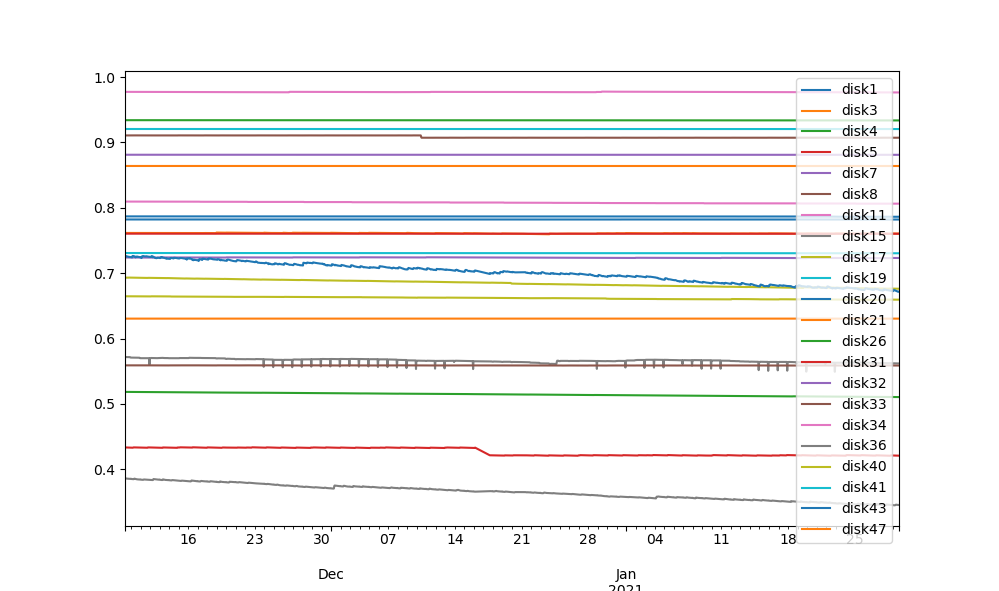

In [40]:
mono_df.plot()

Nous allons commencer par étudier le disque numéro 20 qui est présent au milieu du graphique (en couleur bleu) qui a clairement une tendance négative et qui subit des petites fluctuations. Il semble évoluer entre 0.73 et 0.70 sur les 3 mois de données dont nous disposons.

Comme nous le disions tout à l'heure, nous allons commencer par établir un modèle simple pour commencer, en l'occurence des modèles autoregressifs.

Traçons un lag plot pour identifier la relation entre $y(t)$ et $y(t+1)$

<IPython.core.display.Javascript object>


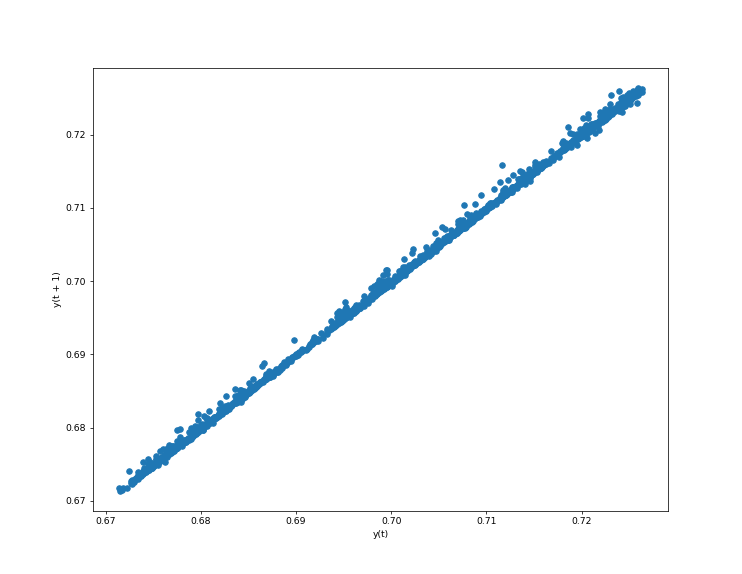

In [469]:
plt.figure()
lag_plot(mono_df['disk20'])

On relève effectivement une relation linéaire entre y(t) et y(t+1) au vu du graphique. Cela est logique dans la mesure où nous disposons d'une tendance négative dans notre signal.

Pour aller plus loin, nous nous proposons de tracer les ACF et PACF du signal **différencié** pour étudier l'influence des différents lags sur l'évolution du stockage du disque 20.

25


<IPython.core.display.Javascript object>


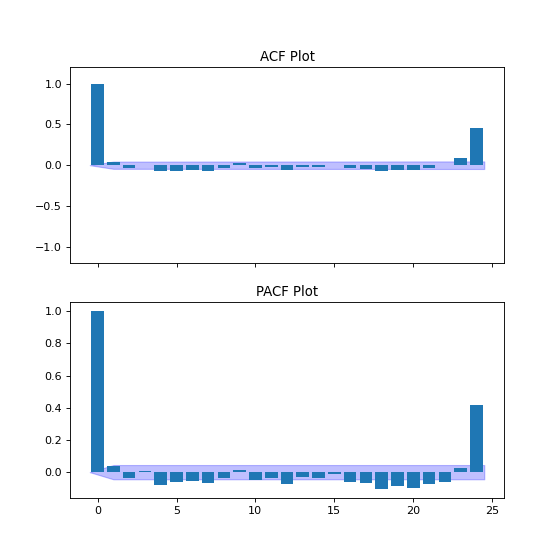

In [874]:
# see functions section at beginning of notebook for more information about 
# "plot_cf" function
diff_df = mono_df[['disk20']].diff().dropna()
plot_cf(diff_df, 24)

Comme nous pouvons le voir, on remarque différentes valeurs de lags significatives pour l'ACF et la PACF. Dans notre cas, nous nous intéressons seulement à la courbe du PACF.

Il faut ignorer le lag zéro bien sûr car il correspond à l'autocorrélation de la timeseries elle-même.

On remarque que le lag 1 et significatif et que le lag 24 l'est également. Cela est dû au fait que le disque 20 a une saisonnalité de 24h. Le lecteur pourra zoomer sur le graphe pour confirmer.

Nous allons donc choisir pour notre modèle le lag 1 et la lag 24.

On laisse le lecteur se référer à la bibliographie pour plus d'informations sur les modèles mathématiques autorégressifs.

#### AR Model

Construisons notre modèle et étudions ses performances

In [182]:
disk = 'disk20'

y = mono_df[disk]
train_end = mono_df.index[round(1953*0.66)]

test_start = train_end + timedelta(seconds=3600)
test_end = test_start + timedelta(days=28) # 28 days forecasting

train_data = y[:train_end]
test_data = y[test_start:test_end]


# Parameters of the model
model = AutoReg(train_data, lags=[1, 24])
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
predictions = model_fit.predict(start=test_start, end=test_end, dynamic=False)
residual = predictions - test_data
print('Mean Absolute Percent Error: ', round(np.mean(abs(residual/test_data)),4)*100, '%')
print('Root Mean Square Error :', np.sqrt(np.mean(residual**2)))

Coefficients: intercept     0.000722
disk20.L1     0.920931
disk20.L24    0.077956
dtype: float64
Mean Absolute Percent Error:  1.04 %
Root Mean Square Error : 0.007629256017764064


On remarque que notre modèle se débrouille plutôt bien avec une MAPE d'environ 1%. Cette métrique signifie que nous nous trompons de 1% en terme de proportion vis-à-vis de la valeur observée lorsque nous réalisons une prédiction. Si l'on s'intéresse à la RMSE, on voit que nous réalisons une erreur de 0.7% d'espace occupé en moyenne ce qui est relativement acceptable étant donné le nombre de valeurs prédites. Observons maintenant nos prédictions sur un graphique.

In [47]:
train_data

2020-11-09 08:00:00    0.726370
2020-11-09 09:00:00    0.725811
2020-11-09 10:00:00    0.726068
2020-11-09 11:00:00    0.725873
2020-11-09 12:00:00    0.725394
                         ...   
2021-01-01 21:00:00    0.694241
2021-01-01 22:00:00    0.694056
2021-01-01 23:00:00    0.694286
2021-01-02 00:00:00    0.695061
2021-01-02 01:00:00    0.694907
Freq: H, Name: disk20, Length: 1290, dtype: float64

In [48]:
test_data

2021-01-02 02:00:00    0.695830
2021-01-02 03:00:00    0.695690
2021-01-02 04:00:00    0.695608
2021-01-02 05:00:00    0.695491
2021-01-02 06:00:00    0.695327
                         ...   
2021-01-29 12:00:00    0.671807
2021-01-29 13:00:00    0.671712
2021-01-29 14:00:00    0.671496
2021-01-29 15:00:00    0.671387
2021-01-29 16:00:00    0.671775
Freq: H, Name: disk20, Length: 663, dtype: float64

<IPython.core.display.Javascript object>


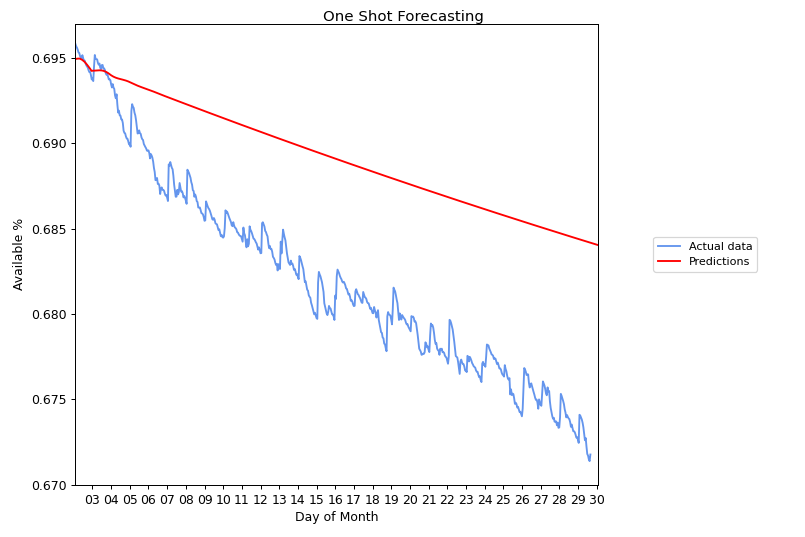

In [153]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)


pax.plot(predictions.index, predictions,
         label="Predictions",
         color="red", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_start, test_end)
pax.set_ylim(0.67,0.697)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One Shot Forecasting")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


A cette échelle la prédiction semble acceptable même si l'erreur s'amplifie au fur et à mesure que la prédiction est lointaine. Cela est normal puisque l'erreur s'accumule au fur et à mesure que nous réalisons notre prédiction. Nous pouvons également plotter l'erreur en fonction du temps pour avoir une meilleure idée de notre modèle.

<IPython.core.display.Javascript object>


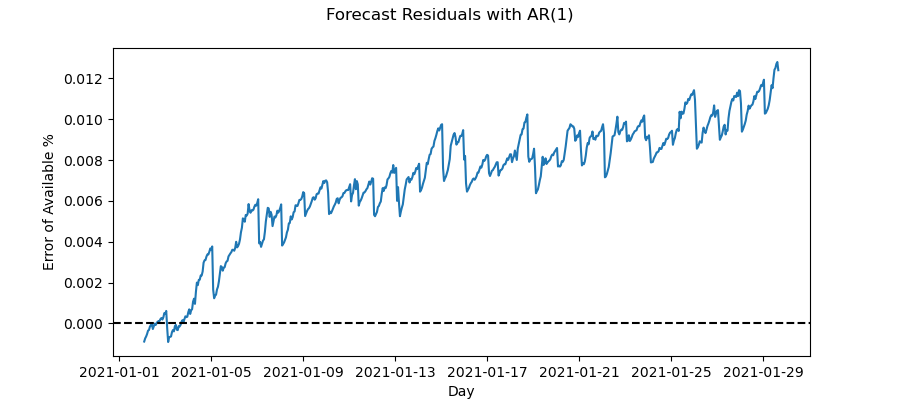

C:\Users\goget\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


Text(0.5, 0.98, 'Forecast Residuals with AR(1)')

In [50]:
fig = plt.figure(figsize=(9,4))
plt.plot(residual)
plt.axhline(0, linestyle='--', color='k')

ax = fig.add_subplot(111)


years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')


# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')


pax.set_xlim(test_start, test_end)


ax.set_ylabel("Error of Available %")
ax.set_xlabel("Day")


fig.suptitle('Forecast Residuals with AR(1)')

On voit bien que notre erreur s'accumule avec les prédictions. 

Pour pallier ce problème d'erreurs accumulées il est possible de faire des prédicitions pas de temps par pas de temps. C'est à dire que nous allons réaliser une prédiction pour l'heure suivante, prendre en compte la valeur actuelle, et réaliser à nouveau une prédiction pour l'heure d'après. Nous avons ici beaucoup plus de chance de pouvoir suivre l'évolution des disques durs et de ce fait éviter que l'erreur s'accumule.

In [179]:

#tab_pred = []
rolling_predictions = test_data.copy()
for rol_end in test_data.index:
    test_st = rol_end + timedelta(seconds=3600)
    #test_nd = test_st + timedelta(day=1) 
    tr_data = y[:rol_end]
    model = AutoReg(tr_data, lags=[1,24])
    model_fit = model.fit()
    predictions = model_fit.predict(start=test_st, end=test_st, dynamic=False)
    rolling_predictions[rol_end] = predictions

    
rolling_residuals = rolling_predictions - test_data
print('Mean Absolute Percent Error: ', round(np.mean(abs(rolling_residuals/test_data)),4)*100, '%')
print('Root Mean Square Error :', np.sqrt(np.mean(rolling_residuals**2)))

Mean Absolute Percent Error:  0.01 %
Root Mean Square Error : 8.145588329646376e-05


On remarque que notre erreur est quasiment nulle avec une MAPE de 0.1% et une RMSE de l'ordre de 10E-5. Regardons maintenant le plot.

<IPython.core.display.Javascript object>


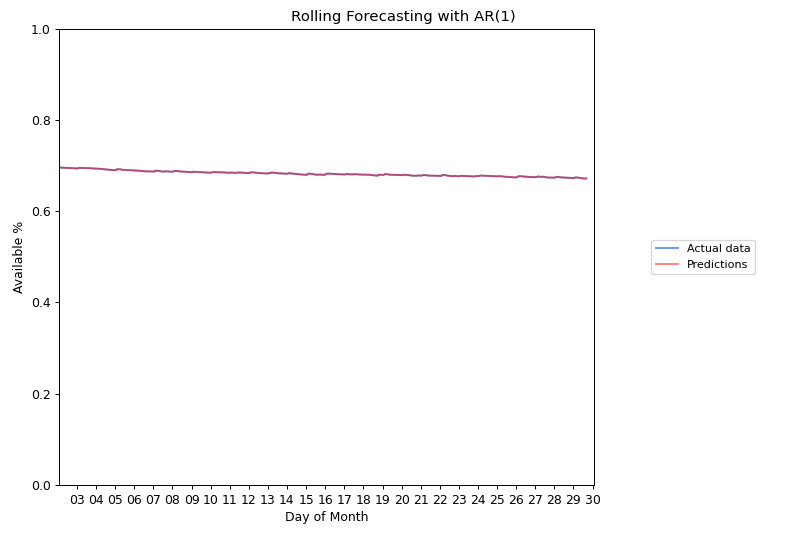

In [178]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)



#for i, pred in enumerate(tab_pred):
pax.plot(rolling_predictions.index, rolling_predictions,
         label="Predictions",
         color="red", linewidth=1.5, alpha=0.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_start, test_end)
pax.set_ylim(0,1)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)



# ----------------

fig.suptitle("Rolling Forecasting with AR(1)")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])



En effet les prédictions suivent parfaitement l'évolution du signal. Le lecteur pourra zoomer pour mieux observer les erreurs.

<IPython.core.display.Javascript object>


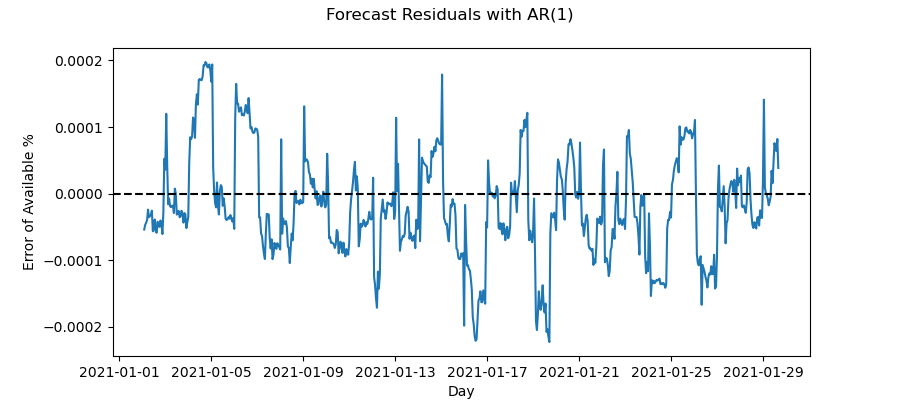

C:\Users\goget\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


Text(0.5, 0.98, 'Forecast Residuals with AR(1)')

In [55]:
fig = plt.figure(figsize=(9,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')

ax = fig.add_subplot(111)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')

pax.set_xlim(test_start, test_end)
pax.set_ylim(-1,1)



ax.set_ylabel("Error of Available %")
ax.set_xlabel("Day")


fig.suptitle('Forecast Residuals with AR(1)')

##### Rolling 15 days predictions

Nous allons maintenant faire une combinaison des deux modèles avec une prédictions sur 15 jours à laquelle nous appliquons une fenêtre glissante.

In [184]:
disk = 'disk20'

y = mono_df[disk]
train_end = mono_df.index[round(1953*0.66)]

test_start = train_end + timedelta(seconds=3600)
# test_end = test_start + timedelta(days=15)

train_data = y[:train_end]
test_data = y[test_start:]

In [189]:
tab_pred = []
tab_mape = []
tab_mae = []
tab_rmse = []
#rolling_predictions = test_data.copy()
for rol_end in test_data.index:
    test_st = rol_end + timedelta(seconds=3600)
    test_nd = test_st + timedelta(days=15)
    tr_data = y[:rol_end]
    model = AutoReg(tr_data, lags=[1, 24])
    model_fit = model.fit()
    predictions = model_fit.predict(start=test_st, end=test_nd, dynamic=False) # forecasting 15 days ahead
    tab_pred.append(predictions)
    if rol_end <= test_data.index[-1]:
        residual = predictions - y[test_st:test_nd]
        tab_mape.append(round(np.mean(abs(residual/test_data)),4)*100)
        tab_mae.append(np.mean(abs(residual)))
        tab_rmse.append(np.sqrt(np.mean(residual**2)))
    #rolling_predictions[rol_end] = predictions


<IPython.core.display.Javascript object>


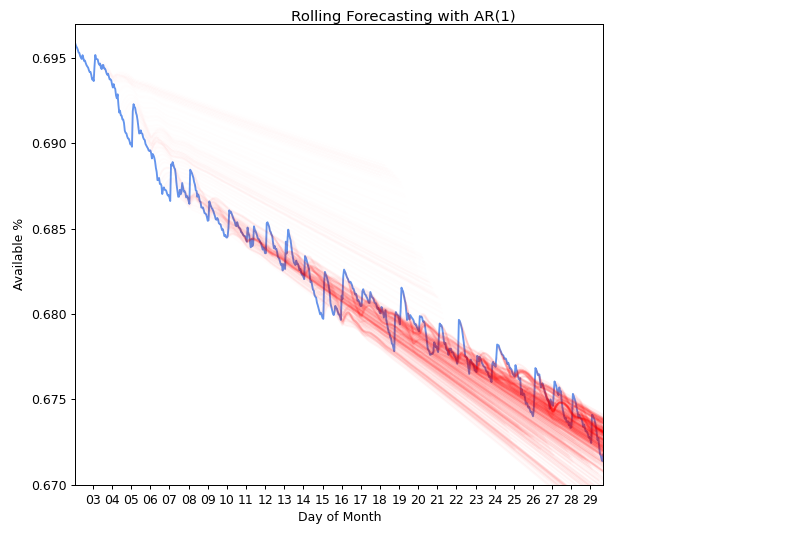

In [166]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)



for i, pred in enumerate(tab_pred):
    pax.plot(pred.index, pred,
             label="Predictions",
             color="red", linewidth=1.5, alpha=0.0001*i)
    
    


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
#pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_data.index[0], y.index[-1])
pax.set_ylim(0.67,0.697)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
#lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Rolling Forecasting with AR(1)")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


On obtient donc un réseau de courbes de prédicitons qui limitent l'amplification des erreurs. Cette méthode de prédiction est intéressante dans la mesure où elle permet de prédire sur de nombreuses heures tout en actualisant le modèle chaque heure. On retrouve bien sûr les plots des erreurs qui cette fois représentent la moyenne des erreurs pour chacune des courbes sur toute la durée de la prédiction.

<IPython.core.display.Javascript object>


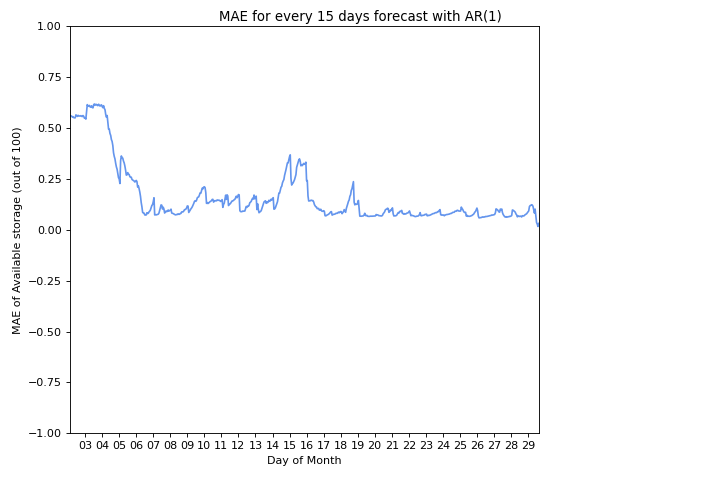

In [870]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs

plot_mae =  [mae * 100 for mae in tab_mae]
pax.plot(test_data.index, plot_mae, 
         label="MAPE Error for every 15 days predictions",
         color="cornflowerblue", linewidth=1.5)
         
    


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_data.index[0], test_data.index[-1])
pax.set_ylim(-1,1)

pax, lax = axs
pax.set_ylabel("MAE of Available storage (out of 100)")
pax.set_xlabel("Day of Month")
lax.axis('off')
#lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("MAE for every 15 days forecast with AR(1)")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


<IPython.core.display.Javascript object>


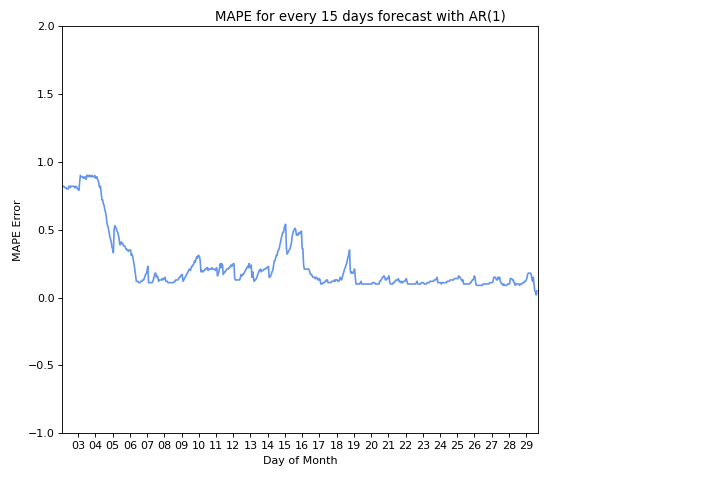

In [871]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs

# plot_mae =  [mae * 100 for mae in tab_mae]
pax.plot(test_data.index, tab_mape, 
         label="MAPE Error for every 15 days predictions",
         color="cornflowerblue", linewidth=1.5)
         
    


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_data.index[0], test_data.index[-1])
pax.set_ylim(-1,2)

pax, lax = axs
pax.set_ylabel("MAPE Error")
pax.set_xlabel("Day of Month")
lax.axis('off')
#lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("MAPE for every 15 days forecast with AR(1)")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


#### ARIMA Model

On essaye cette fois-ci le modèle ARIMA en appliquant une différenciation tout en gardant un ordre 1 pour le lag.

In [62]:
disk = 'disk20'

y = mono_df[disk]
train_end = mono_df.index[round(1953*0.66)]

test_start = train_end + timedelta(seconds=3600)
test_end = test_start + timedelta(days=27)

train_data = y[:train_end]
test_data = y[test_start:test_end]


model = ARIMA(train_data, order=(1, 1, 0)) # Differenciation
model_fit = model.fit()

predictions = model_fit.predict(start=test_start, end=test_end, dynamic=False)
residual = predictions - test_data
print('Mean Absolute Percent Error: ', round(np.mean(abs(residual/test_data)),4)*100, '%')
print('Root Mean Square Error :', np.sqrt(np.mean(residual**2)))


Mean Absolute Percent Error:  1.83 %
Root Mean Square Error : 0.013741325870631598


On remarque que ce modèle n'apporte pas d'amélioration à nos prédictions au vue des métriques d'erreurs.

<IPython.core.display.Javascript object>


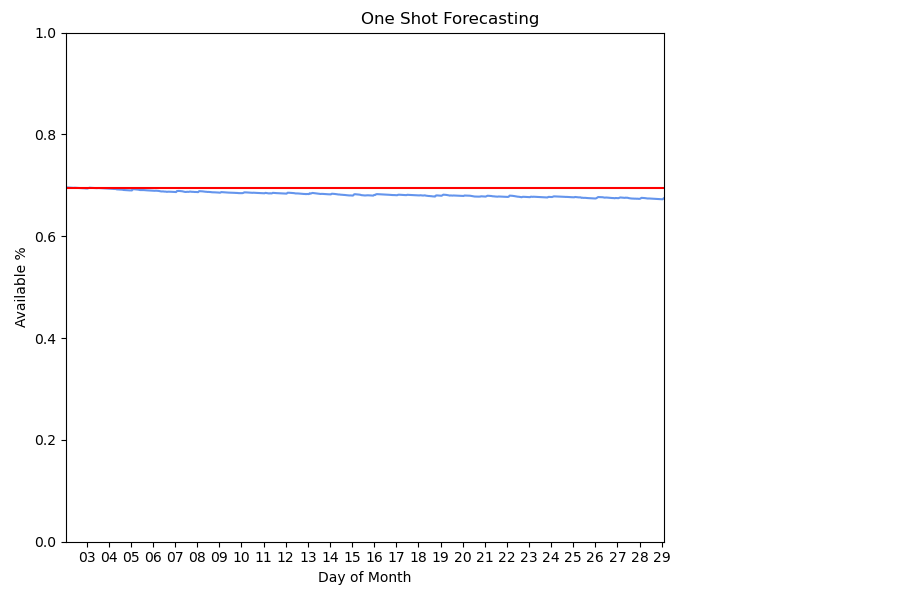

In [67]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)


pax.plot(predictions.index, predictions,
         label="Predictions",
         color="red", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
hour = mdates.HourLocator() 
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_start, test_end)
pax.set_ylim(0,1)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
#lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

pax.set_xlim(test_start, test_end)
pax.set_ylim(0,1)

# ----------------

fig.suptitle("One Shot Forecasting")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


#### SARIMA

Enfin on se propose d'établir un modèle SARIMA prenant en compte la saisonnalité. Pour cela nous choisissons une configuration du modèle de: <br>
$(p, d, q)x(P, D, Q, m) = (1,1,0)x(0,1,1,24)$

De cette manière nous appliquons une différenciation sur la timeseries tout en utilisant le lag 1 pour la partie AR et le lag 24 pour la partie saisonnalité que nous considérons pour la partie MA.

In [74]:
disk = 'disk20'


y = mono_df[disk]
train_end = mono_df.index[round(1953*0.66)]


test_start = train_end + timedelta(seconds=3600)
test_end = test_start + timedelta(days=27)


train_data = y[:train_end]
test_data = y[test_start:test_end]


order = (1,1,0)
sea_order = (0,1,1,24)
model = SARIMAX(train_data, order=order, seasonal_order=sea_order)
model_fit = model.fit()

predictions = model_fit.forecast(len(test_data)) # Performing predictions
predictions = pd.Series(predictions, index=test_data.index)


residual = predictions - test_data
print('Mean Absolute Percent Error: ', round(np.mean(abs(residual/test_data)),4)*100, '%')
print('Root Mean Square Error :', np.sqrt(np.mean(residual**2)))

D:\logiciel\Anaconda\envs\ml_work\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Mean Absolute Percent Error:  1.48 %
Root Mean Square Error : 0.010893746977541951


Bien que la fonction nous indique que nous n'avons pas pu converger vers la solution, nous obtenous une MAPE de 1.48% et une RMSE de 0.001.

<IPython.core.display.Javascript object>


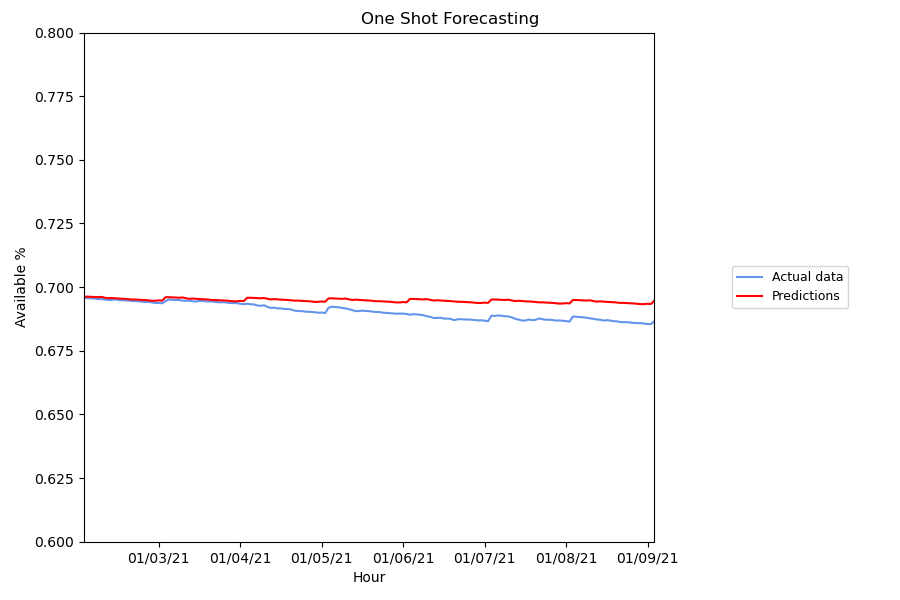

In [73]:
# monthly_df['rol_predictions'] = rolling_predictions

# df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)


pax.plot(predictions.index, predictions,
         label="Predictions",
         color="red", linewidth=1.5)


#pax.grid(True)


years = mdates.YearLocator() 
months = mdates.MonthLocator()
hour = mdates.HourLocator() 
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%D')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_start, test_end)
pax.set_ylim(0.6,0.8)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Hour")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One Shot Forecasting")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


On remarque que ce modèle est en mesure de récupérer la saisonalité mais comme ces prédecesseurs a une erreur qui augmente avec le temps. Il appartiendra aux décideurs du projet de choisir ou non d'établir la saisonnalité dans ce modèle dans la mesure où les fluctuations sont de faibles amplitudes.

Maintenant que nous avons étudié les performances de différents modèles nous allons tester le modèle le plus simple sur le disque 36 qui présentait le niveau le plus bas et qui a donc une probabilité plus élevé de se retrouver saturé. Nous retenons le premier Modèle Autoregressif utilisant les lags 1 et 24.

In [82]:
disk = 'disk36'

y = mono_df[disk]
train_end = mono_df.index[round(1953*0.66)]

test_start = train_end + timedelta(seconds=3600)
test_end = test_start + timedelta(days=27)

train_data = y[:train_end]
test_data = y[test_start:test_end]



model = AutoReg(train_data, lags=[1, 24])
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
predictions = model_fit.predict(start=test_start, end=test_end, dynamic=False)



rmse = sqrt(mean_squared_error(test_data, predictions))
residual = predictions - test_data
print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Percent Error: ', round(np.mean(abs(residual/test_data)),3)*100, '%')

residual = test_data - predictions
# plot results
#plt.figure()
#plt.plot(test_data)
#plt.plot(predictions, color='red')
#plt.show()

Coefficients: intercept    -0.000077
disk36.L1     0.960520
disk36.L24    0.039574
dtype: float64
Test RMSE: 0.003
Mean Absolute Percent Error:  0.7000000000000001 %


<IPython.core.display.Javascript object>


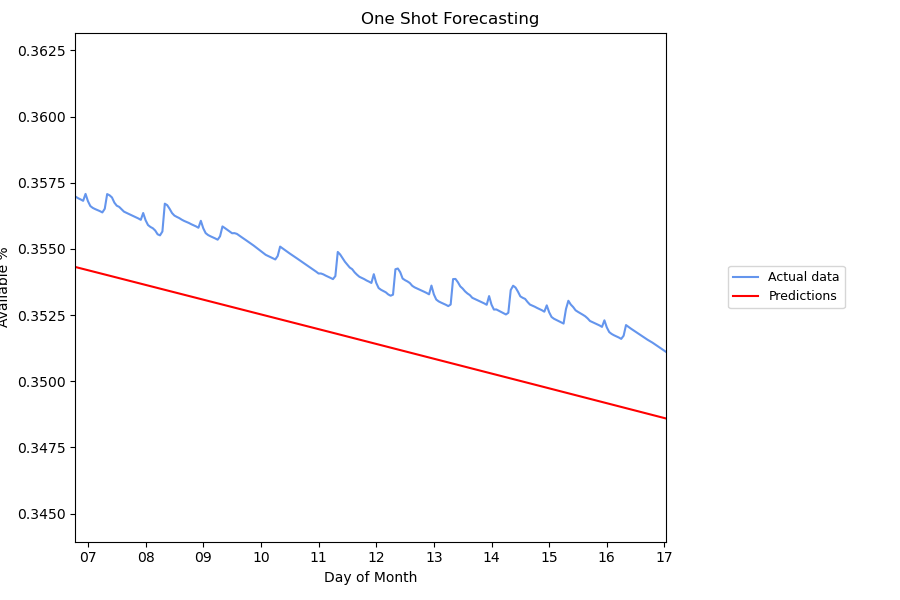

In [80]:
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)


pax.plot(predictions.index, predictions,
         label="Predictions",
         color="red", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d-%m %H')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_start, test_end)
pax.set_ylim(0.3,0.4)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One Shot Forecasting")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])




Il semblerait que le modèle autoregressif d'ordre prenant en compte les lags 1 et 24 se généralise bien dans la mesure où nous obtenons des MAPE faible en prédisant l'intégralité du mois suivant. Une piste pour la suite du projet serait de prédire l'évolution du stockage pour différents disques en essayant ce modèle.

#### Resampling with daily data

Pour terminer ce chapitre sur les prédictions, nous allons essayer de faire une prédiction sur des pas de temps journaliers ce qui permettra de limiter les erreurs sur la durée. pour cela nous faisons un resampling et réalisons une prédicition pour l'intégralité du mois de janvier. Dans la mesure où nous disposons de pas de temps journaliers nous choisissons un lag de 1 seulement.

In [93]:
disk = 'disk36'

y = mono_df[[disk]].resample('D').mean()

y = y[disk]
train_end = y.index[round(82*0.66)]

test_start = train_end + timedelta(days=1)
test_end = test_start + timedelta(days=26)

train_data = y[:train_end]
test_data = y[test_start:test_end]



model = AutoReg(train_data, lags=[1])
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
predictions = model_fit.predict(start=test_start, end=test_end, dynamic=False)



residual = test_data - predictions
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Percent Error: ', round(np.mean(abs(residual/test_data)),4)*100, '%')

residual = test_data - predictions
# plot results
#plt.figure()
#plt.plot(test_data)
#plt.plot(predictions, color='red')
#plt.show()

Coefficients: intercept   -0.000829
disk36.L1    1.000788
dtype: float64
Test RMSE: 0.003
Mean Absolute Percent Error:  0.73 %


<IPython.core.display.Javascript object>


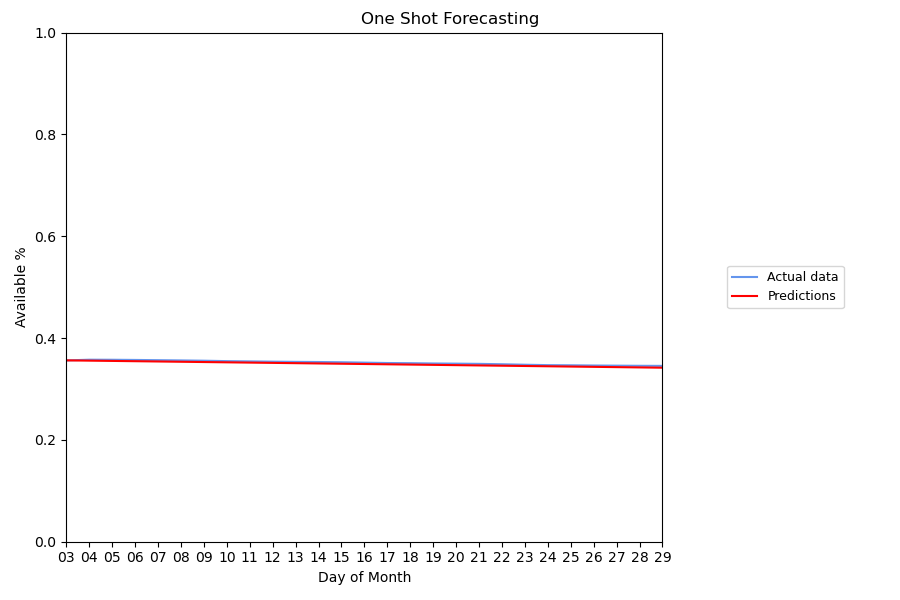

In [94]:
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(test_data.index, test_data.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)


pax.plot(predictions.index, predictions,
         label="Predictions",
         color="red", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
d_fmt = mdates.DateFormatter('%d')

# format the ticks
pax.xaxis.set_major_locator(day)
pax.xaxis.set_major_formatter(d_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%d-%m %H')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(test_start, test_end)
pax.set_ylim(0,1)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One Shot Forecasting")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


Le graphique met bien en évidence la limitation des erreurs sur la durée avec des prédictions qui sont proches des valeurs observées.

#### Bonus :  Prédiction pour savoir quand un disque dur sera plein

Si on essaye de faire l'approximation par un modèle linéaire en se basant sur les 2 dernières prédictions du modèle autoreggressif, il est serait possible de trouver une date approximative à laquelle le disque dur sera saturé. En effet, Nous relevons des valeurs de 0.345034 et 0.344860 pour les deux derniers pas de temps. Si nous modélisons une droite passant par ces deux points nous pouvons trouver une droite de la forme y = ax + b et ainsi résoudre le système pour y = 0. Il nous suffit juste de calculer l'ordonnée à l'origine ainsi que le coefficient directeur de la droite. Il est impossible d'utiliser le modèle autoregressif pour faire une prédiciton sur une aussi grande durée dans la mesure où nous travaillons avec des valeurs inférieures à 1 qui converge vers une valeurs non nulle lorsque l'on répéte l'opération $y(t+1) = alpha.y(t)$    avec $0< alpha < 1$

Si on considère les valeurs 0.345034 et 0.344860 et que l'on considère x en unité de temps journalière on obtient donc:


In [139]:
a = 0.344860-0.345034 # On prend ici x(t)-x(t-1) = 1 comme nous travaillons avec des journées
b = 0.345034

On obtient donc y = 0 pour x = -b/a

In [142]:
x = -b/a
print("Plein après", x, "jours")
print("Plein après", round(x/365,2), "années")

Plein après 1982.9540229884205 jours
Plein après 5.43 années


On obtiendrai donc un disque plein au bout de 1982.9 jours ce qui correspond à environ jours. Si on plot ce modèle linéaire on obtient le graphique suivant.

<IPython.core.display.Javascript object>


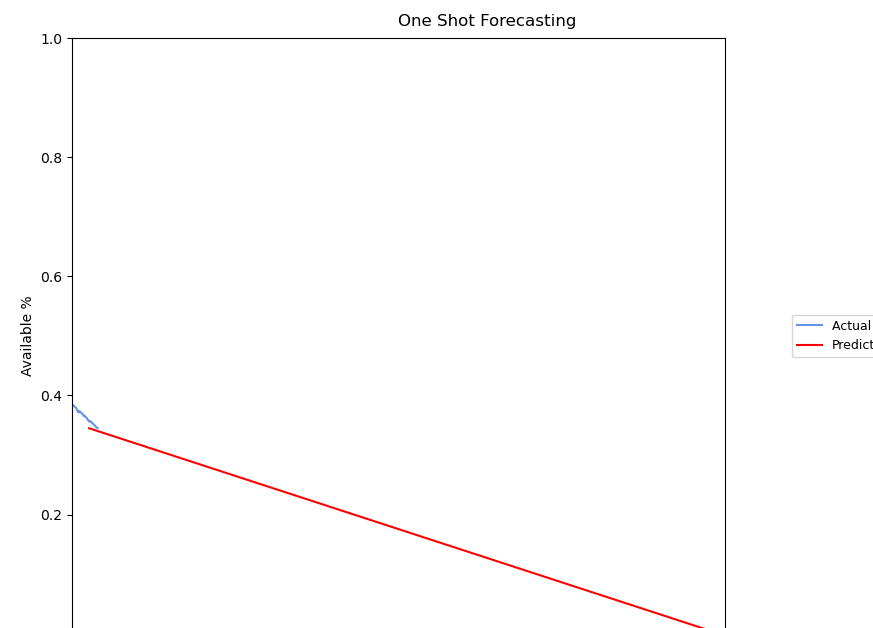

In [119]:
disk = 'disk36'

#y = mono_df[[disk]].resample('D').mean()
#y = y[disk]
#train_end = y.index[-1]
#y_bis_values = [v*100 for v in y.values.tolist()]


a = -0.000174 
b = 0.345034


date = pd.date_range(train_end, periods=2000).tolist()
pred_values = [a*x+b for x in range(len(date))]





# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(y.index, y.values, 
         label="Actual data",
         color="cornflowerblue", linewidth=1.5)


pax.plot(date, pred_values,
         label="Predictions",
         color="red", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.DayLocator()
y_fmt = mdates.DateFormatter('%Y')


# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(y_fmt)
pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#pax.grid(True)


pax.set_xlim(y.index[0], date[-1])
pax.set_ylim(0,1)

pax, lax = axs
pax.set_ylabel("Available %")
pax.set_xlabel("Day of Month")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One Shot Forecasting")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


Si on réalise une approximation par une droite linéaire, on peut remarquer que le disque 36 sera plein d'ici juin 2026 si la tendance reste la même. Cela dit, nous sommes conscient que le modèle est très approximatif et qu'il pourrait être intéressant de faire une prédiction sur tout le mois de janvier comme sur les modèles précédents au pas de temps horaire. Essayer de fitter une régression linéaire sur l'ensemble des valeurs prédites et ensuite utiliser ce nouveau modèle pour prédire à partir de quel moment le disque sera saturé.

La suite du projet consistaitait à tester divers modèles de prédicitons sur les siganux présentant une saisonnalité et d'autres signaux plus complexes mais faute de temps nous n'avons pas pu établir des modèles supplémentaires. Cela dit, le lecteur a accès à la classifications des différents disques et pourra continuer le projet.<br> Pour les signaux de la classe (3) des modèles SARIMA sont à priviligiés tandis que pour la classe 1 et 4 des modèles plus complexes comme FBprophet ou des modèles de réseaux de neurones sont préférables.

#### Signaux issus du cluster variation saisonnière (classe 3)

In [845]:
list_seasonal = dic_results['norm_std_4'][3].copy()
sea_df = trend_df[list_seasonal].copy()
sea_df.head()

disk2     disk6   disk12    disk13    disk23  \
2020-11-09 08:00:00  0.574365  0.572082  0.17111  0.842004  0.427676   
2020-11-09 09:00:00  0.574365  0.572062  0.17111  0.842004  0.427647   
2020-11-09 10:00:00  0.574365  0.572028  0.17111  0.842004  0.427393   
2020-11-09 11:00:00  0.574365  0.571986  0.17111  0.842004  0.426913   
2020-11-09 12:00:00  0.574365  0.571948  0.17111  0.842004  0.425142   

                       disk25    disk28    disk29    disk30    disk37  \
2020-11-09 08:00:00  0.747219  0.574279  0.394921  0.476971  0.904840   
2020-11-09 09:00:00  0.747206  0.574269  0.394921  0.476886  0.904837   
2020-11-09 10:00:00  0.747197  0.574249  0.394921  0.476634  0.904831   
2020-11-09 11:00:00  0.747190  0.574236  0.394921  0.476328  0.904826   
2020-11-09 12:00:00  0.747180  0.574219  0.394921  0.476057  0.904821   

                       disk38    disk39    disk44    disk45  
2020-11-09 08:00:00  0.422413  0.529299  0.488830  0.494440  
2020-11-09 09:00:00  0.422413  0.529289  0.489055  0.494433  
2020-11-09 10:00:00  0.422413  0.529273  0.488964  0.494423  
2020-11-09 11:00:00  0.422413  0.529257  0.488784  0.494411  
2020-11-09 12:00:00  0.422413  0.529240  0.488999  0.494400

<IPython.core.display.Javascript object>


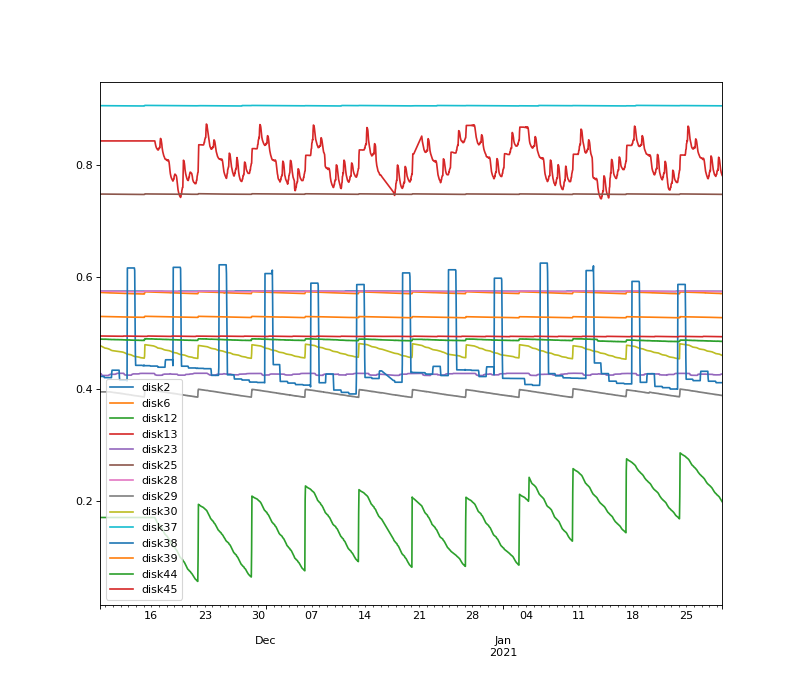

In [846]:
sea_df.plot()

### Conclusion

Pour conclure, bien que ce Notebook est très dense avec beaucoup d'informations, encore beaucoup de choses sont à analyser et à prédire. Nous avons indiqué les pistes d'améliorations pour le lecteur qui pourra reprendre le projet. <br>


_Le chemin est encore long mais la route est tracé...Bon courage et prenez soin de vous._
**_SIMDOU_**

**References used to conduct the project** :
* Mehdi Kaytoue (2021). _Cours de Data Mining_. INSA Lyon
* Ritvikmath, (2020). _Time Series Talk : Augmented Dicky Fuller Test_. Youtube video
* Ritvikmath, (2020). _Unit Roots_. Youtube Video
* PyMannKendall, (2020). _PyMannKendall Python Library_. PYPI.ORG
* Michael Fumery, (2020). _Timeseries SARIMA_. Kaggle Notebook
* Vincent Lefieux, (2020). _Modélisation de série temporelles_. Open Classroom
* Bernard Roux, (2019). _Probablity & Statistics_. INSA Lyon
* Jason Brownlee, (2018). _A gentle introduction to SARIMA for timeseries forecasting in Python_. ML Mastery
* Wes McKinney, (2017). _Python for Data Analysis_. O'reilly


**END OF NOTEBOOK**